# Team
- **Tommaso Giordano**,
- **Guido Gonnella**,
- **Andrea Migliorini**,
- **Simone Oggioni**,
- **Luca Olivieri**.

**Video**: https://drive.google.com/file/d/1PacfOhmIsuAtYV4P8HEvrRlB0yHz85rb/view?usp=share_link

---

# LLMs

In this section, we are going to present some experimentation of ours facing the **classification**/**question-answering** task.

Despite the dataset being marked for question-answering in the project specifications, it is more convenient to consider it for classification: this way, we can rely on classification metrics for an objective evaluation of our findings and we can tackle the question-answering problem nonetheless since answers are required to assign a class!

This section is divided into 4 significant parts:
1. **Experiments**: many solutions are tested on top of `Gemma 3 (1B)` (and a humble `LinearRegression`), a small but sophisticated enough modern LLM.
2. **Models**: more powerful LLMs are evaluated in a more delimited context.
3. **Extras**: some failed experiments and the reasons why they failed are presented.

Throughout the whole section, the classification performance will be our first kpi for the assessment. For a fair evaluation, we are going to leverage the same test set and the same *accuracy* metric of the original paper authors. Hence, our results can be directly compared with theirs. Regarding this, here are some important points:


- The **baseline** we are considering is the classifier predicting the majority class (`'yes'` class), achieving ~**55%** accuracy.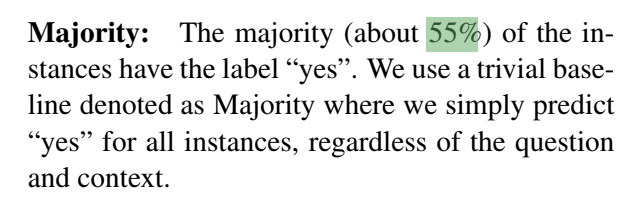

- The **original authors** achieved **68.08%** accuracy in their *reasoning-required* scenario, in which long answers were not given to the their classification `BioBERT` model. Indeed it is equivalent to our scenarion, since we do not feed long answers in input as well.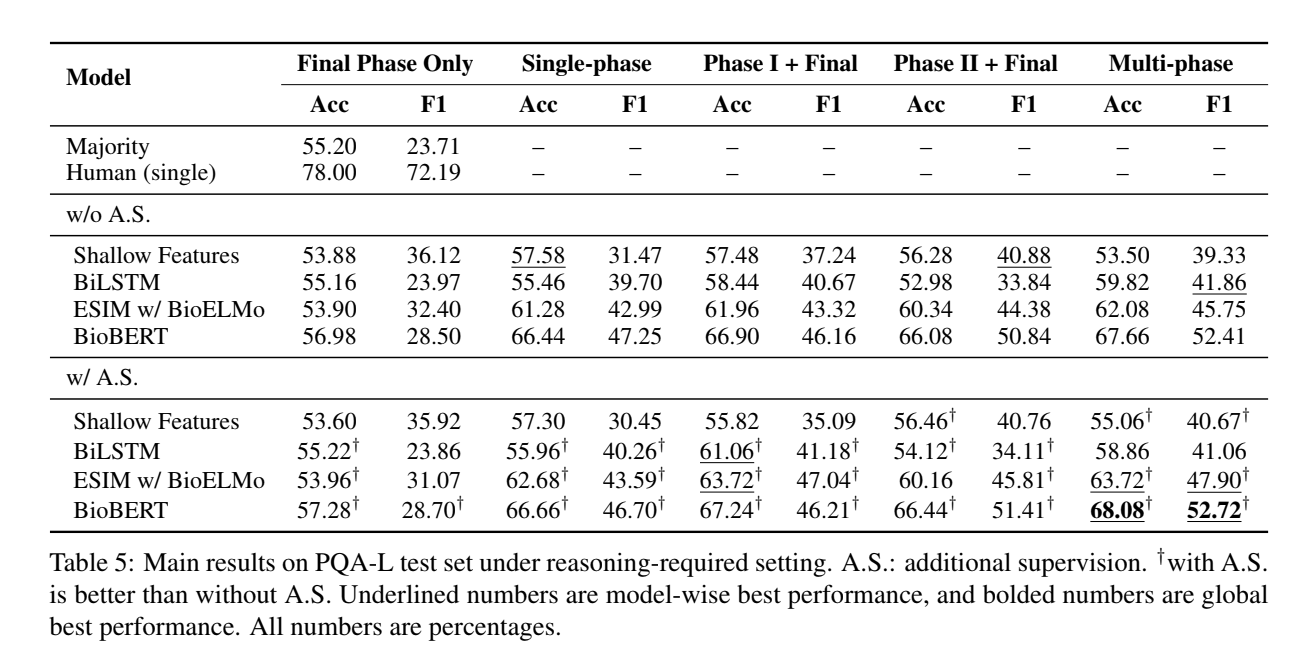

- The **state-of-the-art** has been achieved by Microsoft with GPT-4 (Medprompt) [(Nori et al. 2024)](https://arxiv.org/abs/2311.16452), thanks to a clever use of training-free prompt engineering techniques.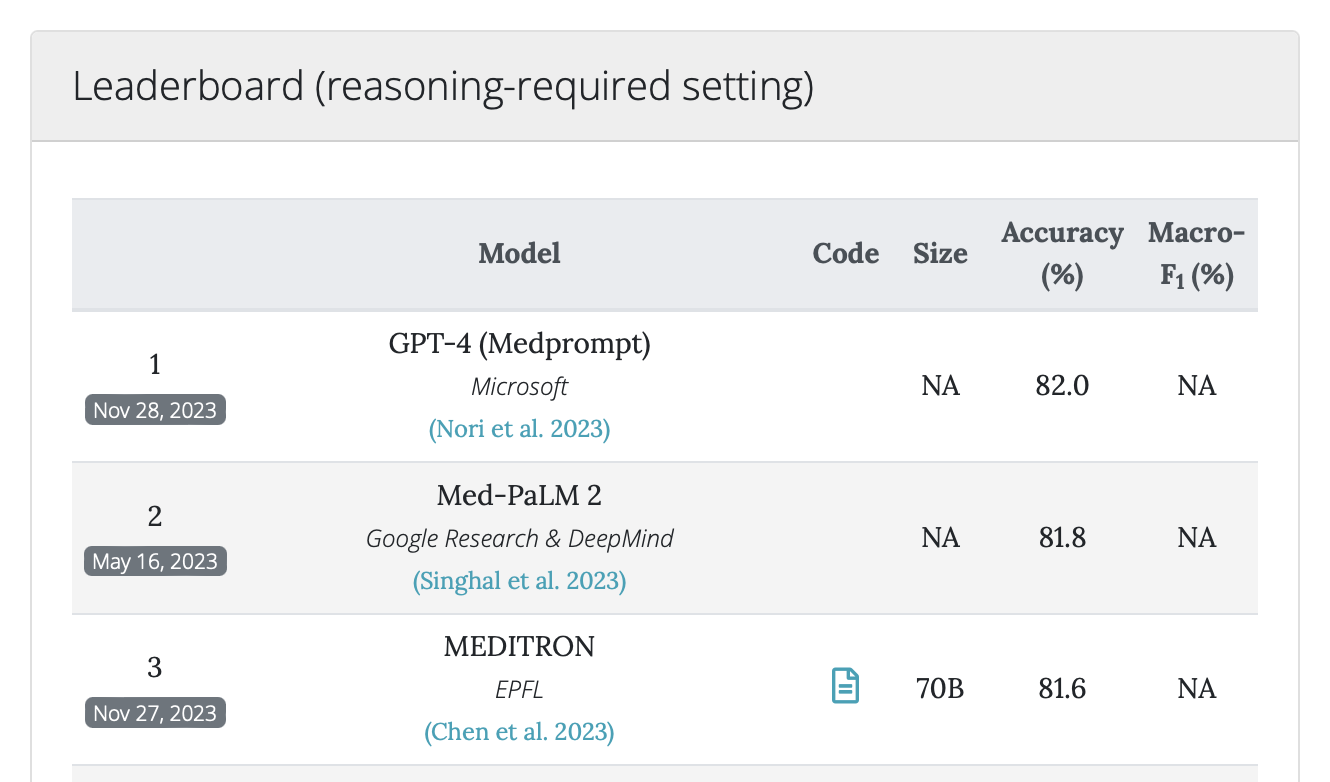

- One noteworthy thing to state is that most of the datasets we will work with are obtained by under-sampling the original datasets, since considering the full datasets would be unfeasible for timeliness and computational reasons.
However, the test set is always tested fully for a fair evaluation.
- Due to our restricted timeliness and computational capabilities, from now on, we are **always** going to use low-bit  quantised models (in some cases 4bits, in others 8bits, depending on the distribution).
- To provide some anticipations, the LLMs will have to format the response in a certain way to allow us to extract reliably the final decision prediction. However, the models (maybe too small) sometimes mess up and do not provide proper formatting. For an whole inference cycle:
    - If the poorly formatted answers are few, we performed manual inspection and assigned manually the correct final decision based on the model showcased outputs.
    - If they are many but still doable, we performed the evaluation on the subset composed by the correctly formatted answers.
    - If they are too many, the evaluation would be performed but considered sort of invalid (luckily, this has never happened in interesting cases).

- To end this introduction, it's important to anticipate that one of the main aspects to keep an I on is the significant difference between the class distribution of the dataset: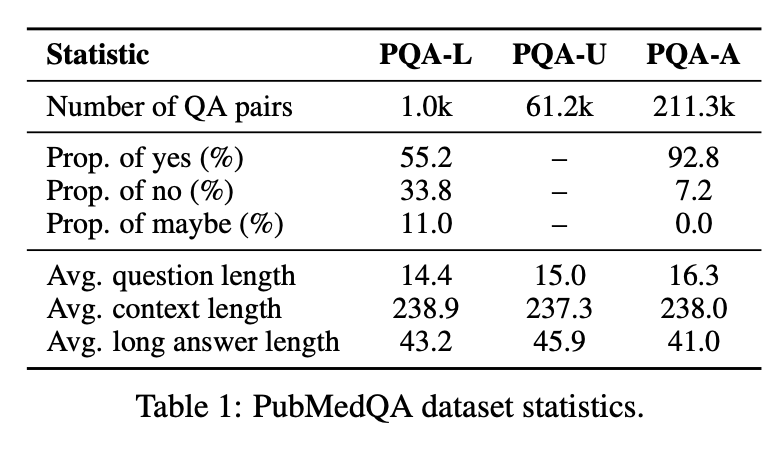
    - **PQA-L** (half of it is the test set, the other half is the validation set) comprise samples from all classes but with varying representation. Indeed, the `'yes'` class is over-represented (55.2%), while the `'maybe'` class is severily under-represented (11%).
    - **PQA-A**, which is the only candidate dataset for supervised training is mostly composed of `'yes'` samples (92.8%) as opposed to `'no'` samples (only 7.2%), but, most importantly, it has no `'maybe'` samples!
    - **PQA-U** has no labels at all so it can only be leveraged for unsupervised and self-supervised learning.

---

# 0.0 Intro

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/pubmedqa/pubmedqa.git
!pip install -q datasets

Cloning into 'pubmedqa'...
remote: Enumerating objects: 40, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 40 (delta 0), reused 1 (delta 0), pack-reused 37 (from 1)
Receiving objects: 100% (40/40), 704.87 KiB | 6.59 MiB/s, done.
Resolving deltas: 100% (12/12), done.


Standard libraries:

In [ ]:
import os
import re
import json
import random
from tqdm.auto import tqdm
from collections import Counter
from IPython.display import Markdown
import subprocess

Viz libraries:

In [ ]:
from IPython.display import Markdown

ML libraries:

In [ ]:
!pip install -q datasets
!pip install -q -U datasets
!pip install -q hnswlib
import numpy as np
import pandas as pd
import hnswlib
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 10.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

NLP libraries:

In [ ]:
!pip install -q --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl==0.15.2 triton cut_cross_entropy unsloth_zoo
!pip install -q sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install -q --no-deps unsloth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.6/146.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 7.8 MB/s eta 0:00:00


In [ ]:
from unsloth import FastModel
from trl import SFTTrainer, SFTConfig
from unsloth.chat_templates import get_chat_template, train_on_responses_only
from datasets import load_dataset
from transformers import TrainingArguments
from transformers import TextStreamer
from sentence_transformers import SentenceTransformer, CrossEncoder, util

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
SEED = 42

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# Create a tqdm progress bar with Hugging Face-like styling
def my_tqdm(data, desc: str = ""):
    return tqdm(
        enumerate(data),
        total=len(data),
        desc=desc,  # Add a description
        unit="item",               # Specify the unit of progress
        colour="#67ad5b",            # Set a vibrant color
        bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]")

---

## Ingestion

In [ ]:
def merge_context(row):
    return {"context": ' '.join(row['context']['contexts'])}

def download_and_process_datasets():
    artificial = load_dataset("qiaojin/PubMedQA", data_files="pqa_artificial/train-00000-of-00001.parquet", split="train")
    labeled = load_dataset("qiaojin/PubMedQA", data_files="pqa_labeled/train-00000-of-00001.parquet", split="train")
    unlabeled = load_dataset("qiaojin/PubMedQA", data_files="pqa_unlabeled/train-00000-of-00001.parquet", split="train")

    artificial = artificial.map(lambda row: merge_context(row))
    labeled = labeled.map(lambda row: merge_context(row))
    unlabeled = unlabeled.map(lambda row: merge_context(row))

    return artificial, labeled, unlabeled

In [ ]:
dfa_a, dfa_l, dfa_u = download_and_process_datasets()

README.md:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/233M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

train-00000-of-00001.parquet:   0%|          | 0.00/66.0M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/211269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/61249 [00:00<?, ? examples/s]

In [ ]:
dfa_a[0]

{'pubid': 25429730,
 'question': 'Are group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?',
 'context': 'Chronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated. The aim of this study was to identify ILC2s in sinus mucosa in patients with CRS and controls and compare ILC2s across characteristics of disease. A cross-sectional study of patients with CRS undergoing endoscopic sinus surgery was conducted. Sinus mucosal biopsies were obtained during surgery and control tissue from patients undergoing pituitary tumour resection through transphenoidal approach. ILC2s were identified as CD45(+) Lin(-) CD127(+) CD4(-) CD8(-) CRTH2(CD294)(+) CD161(+) cells in single cel

We will use **regular expression** to extract the final decision which should be formatted in a precise and univocal way in the LLM answers.

However, since the model tend to make some mistaken with the format, we will use less strict regEx in order to catch most of the  erroneous but still acceptable formats.

The first regEx is the stricter one (but still with some additional cases), while the is even more inclusive and robust to syntactical errors. If the first one gives unacceptable results, we will deploy the second one.

In [ ]:
curly_pattern = re.compile(r'\{\s*(yes|no|maybe)\s*\}')
square_pattern = re.compile(r'\[\s*(yes|no|maybe)\s*\]')
round_pattern = re.compile(r'\(\s*(yes|no|maybe)\s*\)')
quotes_pattern = re.compile(r'"([^"]*)"')

def extract_final_decision(answer: str):
    curly_matches = re.findall(curly_pattern, answer)
    if curly_matches:
        return curly_matches[-1]
    else:
        square_matches = re.findall(square_pattern, answer)
        if square_matches:
            return square_matches[-1]
        else:
            round_matches = re.findall(round_pattern, answer)
            if round_matches:
                return round_matches[-1]
            else:
                quotes_matches = re.findall(quotes_pattern, answer)
                if quotes_matches:
                    return quotes_matches[-1]
    return answer.strip()

inclusive_pattern = re.compile(r'\{\s*([yY]e[sS]|[nN]o|[mM]aybe)\s*\}'
                         r'|\[\s*([yY]e[sS]|[nN]o|[mM]aybe)\s*\]'
                         r'|\(\s*([yY]e[sS]|[nN]o|[mM]aybe)\s*\)'
                         r'|"(.*?(?:[yY]e[sS]|[nN]o|[mM]aybe).*?)"', re.IGNORECASE)
decision_pattern = re.compile(r'([yY]e[sS]|[nN]o|[mM]aybe)', re.IGNORECASE)

def extract_final_decision_inclusive(answer: str):
    matches = re.findall(inclusive_pattern, answer)
    final_decision = None
    if matches:
        for match in matches:
            for group in match:
                if group:
                    decision_match = re.search(decision_pattern, group)
                    if decision_match:
                        final_decision = decision_match.group(1).lower()
    return final_decision if final_decision else answer.strip()

---

# 1.0 Experiments

## Gemma 3 (1B)

In this section we are going to assess `Gemma 3 (1B)` performance in the classification problem. This open-source LLM, released by Google in March 2025, with many interesting features such as Reinforcement Learning, expanded context window, Quantisation-Aware Training and bigger models of the same family have multi-modal capabilities as well. The size is small enough is allow us to experiment with it in many ways:
- Zero-shot.
- One-shot.
- Few-shot.
- Fine-tuning.
- Step-back prompt.

We are going to deploy the `unsloth` release of Gemma 3, which have been made faster with many low-level optimisations, quantised in 4bits for improved speed and size while retaining most of the performance, and unlocked for PEFT fine-tuning.

In [ ]:
model_path = "unsloth/gemma-3-1b-it"
# model_path = "/content/drive/MyDrive/uni/NLP/NLP Project/models/gemma_3_ft"

model, tokenizer = FastModel.from_pretrained(
    model_name = model_path,
    max_seq_length = 2048, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

==((====))==  Unsloth 2025.5.6: Fast Gemma3 patching. Transformers: 4.51.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Using float16 precision for gemma3 won't work! Using float32.


model.safetensors:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/670 [00:00<?, ?B/s]

Let's import the Unsloth processor (tokenizer):

In [ ]:
tokenizer = get_chat_template(
    tokenizer,
    chat_template = "gemma-3",
)

Let's see if the model works:

In [ ]:
messages = [
    {"role": "system",  "content": [{"type": "text", "text": "You are a helpful assistant."}]},
    {"role": "user",    "content": [{"type": "text", "text": "Continue the sequence: 1, 1, 2, 3, 5, 8,"}]}
]

inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt = True, # Must add for generation
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to("cuda")
input_len = inputs["input_ids"].shape[1]

outputs = model.generate(
    **inputs,
    max_new_tokens = 128,
    temperature = 1.0, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

<bos><start_of_turn>user
You are a helpful assistant.

Continue the sequence: 1, 1, 2, 3, 5, 8,<end_of_turn>
<start_of_turn>model
1, 1, 2, 3, 5, 8, **13**

This is the Fibonacci sequence! Each number is the sum of the two preceding numbers.
<end_of_turn>


Let's prepare the model for PEFT (LoRA).

In [ ]:
model = FastModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # Turn off for just text!
    finetune_language_layers   = True,  # Should leave on!
    finetune_attention_modules = True,  # Attention good for GRPO
    finetune_mlp_modules       = True,  # Should leave on always!
    r = 8,           # Larger = higher accuracy, but might overfit
    lora_alpha = 8,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state=SEED,
)

Unsloth: Making `model.base_model.model.model` require gradients


This is the base prompt for zero-shotting the model. The model is given the **question**, the **context** and is asked to output the **long answer** and, sunsequently, the **final decision** (between curly brackets, so that it can be extracted with a regEx).

The assistant prompt defines the target answer which is going to be fed to the model during fine-tuning.

In [ ]:
alpaca_user_prompt = """Below is a question on a certain medical topic, paired with an input that provides further context, useful to answer the question.

1. First, actively reason on the question based on the given context.
2. Then, starting from your reasoning, provide a final decision between curly brackets, choosing among this options:
    - {{yes}}
    - {{no}}
    - {{maybe}}

### Question:
{}

### Input:
{}

### Response:
"""

alpaca_assistant_prompt = """{}

Therefore, the final decision is {{{}}}.
"""

Let's formats the each dataset sample into a turn-taking conversation:

In [ ]:
def formatting_prompts_func(examples):
    questions       = examples["question"]
    contexts        = examples["context"]
    long_answers    = examples["long_answer"]
    final_decisions = examples["final_decision"]
    texts = []
    queries = []
    responses = []
    for question, context, long_answer, final_decision in zip(questions, contexts, long_answers, final_decisions):
        user_text = alpaca_user_prompt.format(question, context)
        assistant_text = alpaca_assistant_prompt.format(long_answer, final_decision)
        response_no_fd_text = long_answer
        query = [
            {"role": "system", "content": "You are a medical assistant. Please be thorough and provide an informative answer."},
            {"role": "user",    "content": user_text},
        ]
        response = [
            {"role": "assistant",   "content": assistant_text},
        ]
        text = [
            {"role": "system", "content": "You are a medical assistant. Please be thorough and provide an informative answer."},
            {"role": "user",        "content": user_text},
            {"role": "assistant",   "content": assistant_text},
        ]
        queries.append(query)
        responses.append(response)
        texts.append(text)
    return {"query": queries, "response": responses, "text" : texts}

In [ ]:
dataset_train = dfa_a.map(formatting_prompts_func, batched = True).select(range(0, dfa_a.num_rows-1, 200))
dataset_eval = dfa_l.map(formatting_prompts_func, batched = True)

Map:   0%|          | 0/211269 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Let's leverage the original validation and test dataset of the authors:

In [ ]:
with open('/content/pubmedqa/data/test_ground_truth.json') as f:
    data = json.load(f)

test_df = pd.DataFrame.from_dict(data, orient='index')
test_idxs = test_df.index.tolist()
len(test_idxs)

500

In [ ]:
dataset_val = dataset_eval.filter(lambda r: str(r["pubid"]) not in test_idxs)
dataset_test = dataset_eval.filter(lambda r: str(r["pubid"]) in test_idxs)

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Let's extract the classes:

In [ ]:
classes = np.unique(dfa_l["final_decision"])
classes

array(['maybe', 'no', 'yes'], dtype='<U5')

Let's inspect a multi-turn conversation (used for SFT).

In [ ]:
s = dataset_train[0]["text"]
s

[{'content': 'You are a medical assistant. Please be thorough and provide an informative answer.',
  'role': 'system'},
 {'content': 'Below is a question on a certain medical topic, paired with an input that provides further context, useful to answer the question.\n\n1. First, actively reason on the question based on the given context.\n2. Then, starting from your reasoning, provide a final decision between curly brackets, choosing among this options:\n    - {yes}\n    - {no}\n    - {maybe}\n\n### Question:\nAre group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?\n\n### Input:\nChronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated. The aim of this study was 

Let's now inspect the same conversation, but with the **chat-template** applied.

In [ ]:
print(tokenizer.apply_chat_template(s, tokenize=False))

<bos><start_of_turn>user
You are a medical assistant. Please be thorough and provide an informative answer.

Below is a question on a certain medical topic, paired with an input that provides further context, useful to answer the question.

1. First, actively reason on the question based on the given context.
2. Then, starting from your reasoning, provide a final decision between curly brackets, choosing among this options:
    - {yes}
    - {no}
    - {maybe}

### Question:
Are group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?

### Input:
Chronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated. The aim of this study was to identify ILC2s in sinus mucosa in 

Let's finally inspect the same conversation but tokenized with Gemma 3 processor:

In [ ]:
print(tokenizer.apply_chat_template(s, tokenize=True))

[2, 105, 2364, 107, 3048, 659, 496, 5526, 16326, 236761, 7323, 577, 13868, 532, 2847, 614, 40564, 3890, 236761, 108, 43760, 563, 496, 2934, 580, 496, 2953, 5526, 10562, 236764, 33481, 607, 614, 2744, 600, 4728, 3342, 4403, 236764, 6684, 531, 3890, 506, 2934, 236761, 108, 236770, 236761, 5315, 236764, 22074, 3282, 580, 506, 2934, 2721, 580, 506, 2238, 4403, 236761, 107, 236778, 236761, 4298, 236764, 6250, 699, 822, 28507, 236764, 2847, 496, 1626, 4893, 1534, 48754, 41706, 236764, 16890, 3571, 672, 3835, 236787, 107, 140, 236772, 642, 4443, 236783, 107, 140, 236772, 642, 1904, 236783, 107, 140, 236772, 642, 60766, 236783, 108, 10354, 19566, 236787, 107, 14219, 2299, 236743, 236778, 66232, 116671, 3874, 568, 564, 11234, 236778, 236751, 1732, 4869, 528, 17044, 15223, 10526, 47288, 11616, 607, 57972, 6356, 975, 653, 124051, 154979, 236881, 108, 10354, 13065, 236787, 107, 179432, 15223, 10526, 47288, 11616, 568, 149337, 236768, 563, 496, 56111, 5933, 607, 614, 12298, 87697, 236761, 6308, 236

After having made sure everything works fine, let's build the dataset splits. For simplicity, we will not asses the performance the validation set but straight on the test set (after all, no actual hyperparameter-tuning phase has been conducted).

In [ ]:
def apply_chat_template(examples):
    texts = tokenizer.apply_chat_template(examples["text"], tokenize=False)
    return { "text" : texts}

messages_train = dataset_train.map(apply_chat_template, batched = True)
messages_val = dataset_val.map(apply_chat_template, batched = True)
messages_test = dataset_test.map(apply_chat_template, batched = True)

Map:   0%|          | 0/1057 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

## Linear Regression

Before deep-diving into LLMs, let's make an attempt with a `LinearRegression` on top of TF-IDF vectors.

We will test two settings:
1. **Reasoning-free**: input vectors concatenating `question`+`long_answer`.
2. **Reasoning-required**: input vectors concatenating `question`+`context`.

**Input**: question+long answers

In [ ]:
d_train = dataset_train.map(lambda r: {"question+long_answer": r["question"]+r["long_answer"]})
d_test = dataset_test.map(lambda r: {"question+long_answer": r["question"]+r["long_answer"]})

Map:   0%|          | 0/1057 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
vectorizer_TFIDF = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
vectorizer_TFIDF.fit(d_train["question+long_answer"])

TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)

LabelEncoder()

In [ ]:
model = LogisticRegression().fit(
    vectorizer_TFIDF.transform(d_train["question+long_answer"]),
    label_enc.transform(d_train["final_decision"]))
print(model)

LogisticRegression()


In [ ]:
predictions = model.predict(vectorizer_TFIDF.transform(d_test["question+long_answer"]))
print(predictions)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 

In [ ]:
sum(predictions == label_enc.transform(d_test["final_decision"]))/len(predictions)

np.float64(0.552)

On no! in the reasoning-free setting the model always predict the majority class!
Let's see the in the other setting we have some differences.

**Input**: question+context

In [ ]:
d_train = dataset_train.map(lambda r: {"question+context": r["question"]+r["context"]})
d_test = dataset_test.map(lambda r: {"question+context": r["question"]+r["context"]})

Map:   0%|          | 0/1057 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
vectorizer_TFIDF = TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')
vectorizer_TFIDF.fit(d_train["question+context"])

TfidfVectorizer(max_df=0.8, min_df=5, stop_words='english')

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)

LabelEncoder()

In [ ]:
model = LogisticRegression().fit(
    vectorizer_TFIDF.transform(d_train["question+context"]),
    label_enc.transform(d_train["final_decision"]))
print(model)

LogisticRegression()


In [ ]:
predictions = model.predict(vectorizer_TFIDF.transform(d_test["question+context"]))
predictions

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [ ]:
sum(predictions == label_enc.transform(d_test["final_decision"]))/len(predictions)

np.float64(0.552)

Same, only the majority class is predicted.

Even before performing the experiments, the `LinearRegression` was arguably an poor option since, in practice, on top of sparse vector representations, is a shallow probabilistic classifier which does not account for linguistic pattern or expressions and can only reason on the amount of words present.

Clearly this is not enough to capture the non-trivial linguistic structures required to answer questions. Elements such as entailments, negations and implications are not capture by such models.

## LLM Inference

Now let's

Let's run the model via Unsloth native inference!

According to the `Gemma 3` team, the recommended settings for inference are `temperature = 1.0, top_p = 0.95, top_k = 64`

In [ ]:
examples = dataset_train["text"]
type(examples), len(examples)

(list, 1057)

**Important**: from now on, all prompts will be prepended with a **system prompt** telling the model to adopt the role of a professional and reliable medical assistant.

$$\text{"You are a medical assistant. Please be thorough and provide an informative answer."}$$

Let's print an example of user-assistant conversation:

In [ ]:
example = examples[0]
example

[{'content': 'Below is a question on a certain medical topic, paired with an input that provides further context, useful to answer the question.\n\n1. First, actively reason on the question based on the given context.\n2. Then, starting from your reasoning, provide a final decision between curly brackets, choosing among this options:\n    - {yes}\n    - {no}\n    - {maybe}\n\n### Question:\nAre group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?\n\n### Input:\nChronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated. The aim of this study was to identify ILC2s in sinus mucosa in patients with CRS and controls and compare ILC2s across characteristics of disease.

This is just the user turn:

In [ ]:
prompt = example[:1]
prompt

[{'content': 'Below is a question on a certain medical topic, paired with an input that provides further context, useful to answer the question.\n\n1. First, actively reason on the question based on the given context.\n2. Then, starting from your reasoning, provide a final decision between curly brackets, choosing among this options:\n    - {yes}\n    - {no}\n    - {maybe}\n\n### Question:\nAre group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?\n\n### Input:\nChronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated. The aim of this study was to identify ILC2s in sinus mucosa in patients with CRS and controls and compare ILC2s across characteristics of disease.

This is just the assistant turn:

In [ ]:
target = example[1:]
target

[{'content': 'As ILC2s are elevated in patients with CRSwNP, they may drive nasal polyp formation in CRS. ILC2s are also linked with high tissue and blood eosinophilia and have a potential role in the activation and survival of eosinophils during the Th2 immune response. The association of innate lymphoid cells in CRS provides insights into its pathogenesis.\n\nTherefore, the final decision is {yes}.\n',
  'role': 'assistant'}]

Everything works, let's proceed with the experiments!

## Zero-shot (no reasoning)

Before proceeding with the regular, reasoning-required answer, let's evaluate the model performance when asked to straight up give the final decision without any reasoning on its behalf.

In [ ]:
alpaca_user_rf_prompt = """Below is a question on a certain medical topic, paired with an input that provides further context, useful to answer the question.

Your task is to provide a only a final decision between curly brackets, choosing among this options:
    - {{yes}}
    - {{no}}
    - {{maybe}}
Avoid to output anything else than the final decision.

### Question:
{}

### Input:
{}

### Response:
"""

In [ ]:
def formatting_prompts_rf_func(examples):
    questions       = examples["question"]
    contexts        = examples["context"]
    final_decisions = examples["final_decision"]
    queries = []
    for question, context, final_decision in zip(questions, contexts, final_decisions):
        user_text = alpaca_user_rf_prompt.format(question, context)
        query = [
            {"role": "system", "content": "You are a medical assistant. Please be thorough and provide an informative answer."},
            {"role": "user",    "content": user_text},
        ]
        queries.append(query)
    return {"query_rf": queries}

In [ ]:
dataset_test = dataset_test.map(formatting_prompts_rf_func, batched = True)

In [ ]:
def gpu_computation_rf(batch):
    # Move the model on the right GPU if it's not there already
    device = "cuda"
    model.to(device)

    cond_inputs = tokenizer.apply_chat_template(
        batch["query_rf"],
        add_generation_prompt = True, # Must add for generation
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        padding=True
    ).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **cond_inputs,
            max_new_tokens = 1024,
            temperature = 1.0, top_p = 0.95, top_k = 64
    )
    batch["output"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

In [ ]:
output_dataset = dataset_test.map(
        gpu_computation_rf,
        batched=True,
        batch_size=64,
        num_proc=torch.cuda.device_count(),  # one process per GPU
)
output_dataset = output_dataset.map(lambda r: {"output": r["output"][r["output"].index("model\n")+6:]})

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
output_dataset["output"][:15]

['\n{yes}',
 ' (yes)',
 's\n',
 '.\n',
 '0',
 '\n{yes}',
 '\n{yes}',
 ' a{{yes} }',
 '\n{yes}',
 ' to the current readiness guidelines based on the epidemiology of encountered HMCIs.',
 'further analysis required.\n',
 ',maybe\n',
 '1\n',
 '1',
 '0.00\n']

There is some non-sense, many answers have not been properly formatted.

Let's see the performance of the properly formatted answers:

In [ ]:
def simple_extract_final_decision(answer: str):
    matches = re.findall(re.compile(r'(yes|no|maybe)'), answer)
    if matches:
        return matches[-1]
    return answer.strip()

bad_idxs = [i for i, x in enumerate([simple_extract_final_decision(s) for s in output_dataset["output"]]) if x not in ["yes", "no", "maybe"]]
len(bad_idxs)

252

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)
preds = label_enc.transform([simple_extract_final_decision(s) for i, s in enumerate(output_dataset["output"]) if i not in bad_idxs])
targets = label_enc.transform([s for i, s in enumerate(output_dataset["final_decision"]) if i not in bad_idxs])

In [ ]:
print(classification_report(targets, preds, target_names=label_enc.classes_, labels=range(len(classes))))
print(confusion_matrix(targets, preds))

              precision    recall  f1-score   support

       maybe       0.08      0.14      0.10        28
          no       0.43      0.31      0.36        81
         yes       0.59      0.58      0.59       139

    accuracy                           0.44       248
   macro avg       0.37      0.34      0.35       248
weighted avg       0.48      0.44      0.46       248

[[ 4  5 19]
 [19 25 37]
 [30 28 81]]


Without the reasoning phase, this is scenarion is quite ill-defined, indeed the accuracy is only **44**%, significantly worse than the majority baseline!

Let's hope for the following experiments to bring better results!

## Zero-shot

From now on we will consider the reasoning-required case: namely, we will ask the model to reason before giving a final decision.

Let's make a first attempt, querying the model without fancy stuff:

In [ ]:
inputs = tokenizer.apply_chat_template(
    prompt,
    add_generation_prompt = True, # Must add for generation
    tokenize=True,
    return_dict=True,
    return_tensors="pt"
).to("cuda")
input_len = inputs["input_ids"].shape[1]

outputs = model.generate(
    **inputs,
    max_new_tokens = 1024,
    temperature = 1.0, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

generated_ids = outputs[0][input_len:]
response = tokenizer.decode(generated_ids, skip_special_tokens=True)

{yes}
<end_of_turn>


That did not go as desired: the model ignored the **reasoning** part (what we would want to be the `long_answer` field of the dataset) and immediatly jumped to the final decision.

To try to solve this issue, I will condition the model by prepending to the `assistant` textual content an introduction for the reasoning part:

In [ ]:
cond_text = tokenizer.apply_chat_template(
    prompt,
    add_generation_prompt=True,
    tokenize=False)
cond_text += "Let's reason on the question based on the available input, I will explain how to infer the answer from the context and then, in the end, will provide the final decision between curly brackets:\n"
cond_text[-300:]

"ted with worsening nasal symptom score in CRS (P = 0.04).\n\n### Response:<end_of_turn>\n<start_of_turn>model\nLet's reason on the question based on the available input, I will explain how to infer the answer from the context and then, in the end, will provide the final decision between curly brackets:\n"

Now the model has been conditioned to reason in a certain way! Let's see if it works:

In [ ]:
cond_inputs = tokenizer.encode_plus(cond_text, return_tensors="pt", add_special_tokens=False).to("cuda")
cond_input_len = cond_inputs["input_ids"].shape[1]

cond_outputs = model.generate(
    **cond_inputs,
    max_new_tokens = 1024,
    temperature = 1.0, top_p = 0.95, top_k = 64,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

cond_generated_ids = cond_outputs[0][cond_input_len:]
cond_response = tokenizer.decode(cond_generated_ids, skip_special_tokens=True)

We can infer that increased ILC2s comprise a subset of innate lymphoid cells within CRS, which is relevant to our understanding of ILC2's role in clinical disease.

Therefore, the final decision is {yes}.<end_of_turn>


In [ ]:
tg = extract_final_decision(target[0]["content"])
pr = extract_final_decision(cond_response)
print("Target:\t\t", tg)
print("Prediction:\t", pr)
print("---")
print("Is the model correct?", tg == pr)

Target:		 yes
Prediction:	 yes
---
Is the model correct? True


Let's perform inference across the whole test dataset:

In [ ]:
def gpu_computation(batch):
    # Move the model on the right GPU if it's not there already
    device = "cuda"
    model.to(device)

    cond_texts = tokenizer.apply_chat_template(
        batch["query"],
        add_generation_prompt=True,
        tokenize=False
    )
    cond_texts = [t + "Let's reason on the question based on the available input, I will explain how to infer the answer from the context and then, in the end, I will provide the final decision between curly brackets:\n" for t in cond_texts]
    cond_inputs = tokenizer.batch_encode_plus(
        cond_texts,
        return_tensors="pt",
        add_special_tokens=False,
        padding=True
    ).to("cuda")
    with torch.no_grad():
        outputs = model.generate(
            **cond_inputs,
            max_new_tokens = 1024,
            temperature = 1.0, top_p = 0.95, top_k = 64
        )
    batch["output"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

In [ ]:
output_dataset = dataset_test.map(
        gpu_computation,
        batched=True,
        batch_size=64,
        num_proc=torch.cuda.device_count(),  # one process per GPU
)
output_dataset = output_dataset.map(lambda r: {"output": r["output"][r["output"].index("model\n")+6:]})

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)
preds = label_enc.transform([extract_final_decision(s) for s in output_dataset["output"]])
targets = label_enc.transform(output_dataset["final_decision"])

In [ ]:
print(classification_report(targets, preds, target_names=label_enc.classes_, labels=range(len(classes))))

              precision    recall  f1-score   support

       maybe       0.08      0.20      0.12        55
          no       0.62      0.22      0.32       169
         yes       0.67      0.74      0.70       276

    accuracy                           0.50       500
   macro avg       0.46      0.39      0.38       500
weighted avg       0.59      0.50      0.51       500



If the model is allowed to reason, the accuracy improves from 40% to **50**%, but we are still behind then the majority baseline (55%)!

Let's proceed with the experiments!

## One-Shot

Let's try one-shotting the model, namely giving an input-output example so that it can understand how to provide a better answer.

Strictly speaking, the right thing to do would be to make an informed selection of the sample trying out many candidate examples both with heuristics and performance-driven criteria.

However, in our case, for simplicity, we take a random sample from the validation set.

In [ ]:
available_ids = [i for i in dataset_val["pubid"]]

In [ ]:
os_sample = dfa_l.filter(lambda r: r["pubid"] == random.choice(available_ids))[0]
os_sample

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

{'pubid': 9191526,
 'question': 'Multidisciplinary breast cancer clinics. Do they work?',
 'context': 'In an attempt to improve the care they provide for their patients with breast cancer, the authors\' institution developed a multidisciplinary breast cancer clinic (MDBCC) to offer "one-stop shopping" consultation and support for newly diagnosed breast cancer patients. One hundred sixty-two patients, the control group for this study, were evaluated at Henry Ford Hospital during the year prior to the opening of the MDBCC. These patients, who were referred in the traditional sequential consultation manner, were compared with the first 177 patients seen during the first year of the clinic\'s operation. Retrospective chart reviews were conducted to assess treatment timeliness, and anonymous questionnaires were used to assess patient satisfaction. The authors found that the MDBCC increased patient satisfaction by encouraging involvement of patients\' families and friends and by helping pati

In [ ]:
alpaca_user_oneshot_prompt = """Below is a question on a certain medical topic, paired with an input that provides further context, useful to answer the question.

1. First, actively reason in on the question based on the given context.
2. Then, starting from your reasoning, provide a final decision between curly brackets, choosing among this options:
    - {{yes}}
    - {{no}}
    - {{maybe}}

To help you, I provide an example of a Question-Input-Response:

### Question:
Multidisciplinary breast cancer clinics. Do they work?

### Input:
In an attempt to improve the care they provide for their patients with breast cancer, the authors\' institution developed a multidisciplinary breast cancer clinic (MDBCC) to offer "one-stop shopping" consultation and support for newly diagnosed breast cancer patients. One hundred sixty-two patients, the control group for this study, were evaluated at Henry Ford Hospital during the year prior to the opening of the MDBCC. These patients, who were referred in the traditional sequential consultation manner, were compared with the first 177 patients seen during the first year of the clinic\'s operation. Retrospective chart reviews were conducted to assess treatment timeliness, and anonymous questionnaires were used to assess patient satisfaction. The authors found that the MDBCC increased patient satisfaction by encouraging involvement of patients\' families and friends and by helping patients make treatment decisions (P<0.001). The time between diagnosis and the initiation of treatment was also significantly decreased (42.2 days vs. 29.6 days; P<0.0008).

### Response:
Although planning and operating a multidisciplinary clinic is not a new venture, to the best of the authors' knowledge, they have provided the first report demonstrating the benefits described above.

Therefore, the final decision is {{yes}}.

---

Now, I provide the actual question and input that you are asked to answer.

### Question:
{}

### Input:
{}

### Response:
"""

In [ ]:
def formatting_prompts_func_oneshot(examples):
    questions       = examples["question"]
    contexts        = examples["context"]
    long_answers    = examples["long_answer"]
    final_decisions = examples["final_decision"]
    texts = []
    queries = []
    responses = []
    for question, context, long_answer, final_decision in zip(questions, contexts, long_answers, final_decisions):
        user_text = alpaca_user_oneshot_prompt.format(question, context)
        assistant_text = alpaca_assistant_prompt.format(long_answer, final_decision)
        text = [
            {"role": "system", "content": "You are a medical assistant. Please be thorough and provide an informative answer."},
            {"role": "user",        "content": user_text},
            {"role": "assistant",   "content": assistant_text}
        ]
        query = [
            {"role": "system", "content": "You are a medical assistant. Please be thorough and provide an informative answer."},
            {"role": "user",    "content": user_text},
        ]
        response = [
            {"role": "assistant",   "content": assistant_text}
        ]
        texts.append(text)
        queries.append(query)
        responses.append(response)
    return {"text_os" : texts, "query_os": queries}
pass

In [ ]:
dataset_test = dataset_test.map(formatting_prompts_func_oneshot, batched = True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
def gpu_computation_oneshot(batch):
    # Move the model on the right GPU if it's not there already
    device = "cuda"
    model.to(device)

    cond_inputs = tokenizer.apply_chat_template(
        batch["query_os"],
        add_generation_prompt = True, # Must add for generation
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        padding=True
    ).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **cond_inputs,
            max_new_tokens = 1024,
            temperature = 1.0, top_p = 0.95, top_k = 64
    )
    batch["output"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

In [ ]:
output_dataset = dataset_test.map(
        gpu_computation_oneshot,
        batched=True,
        batch_size=64,
        num_proc=torch.cuda.device_count(),  # one process per GPU
)
output_dataset = output_dataset.map(lambda r: {"output": r["output"][r["output"].index("model\n")+6:]})

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

After employing a one-shot example, the model could not properly format some answers: likely, the additional tokens made difficult for the model to pay enough attention to the formatting instruction (an issue which is especially severe for small model like ours).

94 samples, almost a fifth of the total number, were not properly formatted and hence were discarded from the evaluation.

In [ ]:
bad_idxs = [i for i, x in enumerate([extract_final_decision(s) for s in output_dataset["output"]]) if x not in ["yes", "no", "maybe"]]
len(bad_idxs)

94

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)
preds = label_enc.transform([extract_final_decision(s) for i, s in enumerate(output_dataset["output"]) if i not in bad_idxs])
targets = label_enc.transform([s for i, s in enumerate(output_dataset["final_decision"]) if i not in bad_idxs])

In [ ]:
print(classification_report(targets, preds, target_names=label_enc.classes_, labels=range(len(classes))))

              precision    recall  f1-score   support

       maybe       0.14      0.37      0.20        46
          no       0.59      0.24      0.34       138
         yes       0.65      0.67      0.66       222

    accuracy                           0.49       406
   macro avg       0.46      0.43      0.40       406
weighted avg       0.57      0.49      0.50       406



In [ ]:
confusion_matrix(targets, preds)

array([[ 17,   5,  24],
       [ 48,  33,  57],
       [ 56,  18, 148]])

One-shotting does not help with the performances, accuracy (**49**%) remains roughly the same as our current personal best (50%).

## Few-Shot

Now, let's try few-shotting the model. We will provide **three** examples (from the validation set), each one representative of a different class (`'yes'`, `'no'`, `'maybe'`). One of the examples is the same one used in the zero-shot scenario.

This way, the LLM has the opportunity to learn from an answer of each class and how they differ.

In [ ]:
no_ids = [i for i in dataset_val.filter(lambda r: r["final_decision"] == "no")["pubid"]]
maybe_ids = [i for i in dataset_val.filter(lambda r: r["final_decision"] == "maybe")["pubid"]]
len(no_ids), len(maybe_ids)

(169, 55)

In [ ]:
no_pubid = random.choice(no_ids)
maybe_pubid = random.choice(maybe_ids)
no_pubid, maybe_pubid

(26784147, 17562682)

In [ ]:
no_sample = dfa_l.filter(lambda r: r["pubid"] == no_pubid)[0]
maybe_sample = dfa_l.filter(lambda r: r["pubid"] == maybe_pubid)[0]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
no_sample

{'pubid': 26784147,
 'question': 'Target Serum Urate: Do Gout Patients Know Their Goal?',
 'context': "To examine gout patients' knowledge of their condition, including the central role of achieving and maintaining the serum urate (SU) goal with the use of urate-lowering therapy (ULT). This study of 612 gout patients was conducted at a Veterans Affairs medical center. Gout patients were included based on administrative diagnostic codes and receipt of at least 1 allopurinol prescription over a 1-year period. Questionnaires were mailed to patients and linked to medical records data. The questionnaire included gout-specific knowledge questions, the Patient Activation Measure, and self-reported health outcomes. Knowledge was assessed descriptively. Multivariable logistic regression was used to determine predictors of SU goal knowledge. Associations of knowledge with health outcomes were examined in exploratory analyses. The questionnaire had a 62% response rate. Only 14% of patients knew t

In [ ]:
maybe_sample

{'pubid': 17562682,
 'question': 'Is Panton-Valentine leucocidin associated with the pathogenesis of Staphylococcus aureus bacteraemia in the UK?',
 'context': 'The morbidity and mortality associated with Panton-Valentine leucocidin (PVL)-positive Staphylococcus aureus suggest that this toxin is a key marker of disease severity. Nevertheless, the importance of PVL in the pathogenesis of primary bacteraemia caused by S. aureus is uncertain. We have determined the prevalence of PVL-encoding genes among isolates of S. aureus from bacteraemic patients. Consecutive bacteraemia isolates of S. aureus (n=244) from patients hospitalized in 25 centres in the UK and Ireland during 2005 were screened for PVL and mecA genes. PVL-positive isolates were characterized by toxin gene profiling, PFGE, spa-typing and MIC determinations for a range of antimicrobials. Four out of 244 isolates (1.6%) were PVL-positive and susceptible to oxacillin [methicillin-susceptible S. aureus (MSSA)]. Eighty-eight out o

In [ ]:
alpaca_user_fewshot_prompt = """Below is a question on a certain medical topic, paired with an input that provides further context, useful to answer the question.

1. First, actively reason in on the question based on the given context.
2. Then, starting from your reasoning, provide a final decision between curly brackets, choosing among this options:
    - {{yes}}
    - {{no}}
    - {{maybe}}

To help you, I provide an example of a Question-Input-Response:

## Example 1
### Question:
Multidisciplinary breast cancer clinics. Do they work?

### Input:
In an attempt to improve the care they provide for their patients with breast cancer, the authors\' institution developed a multidisciplinary breast cancer clinic (MDBCC) to offer "one-stop shopping" consultation and support for newly diagnosed breast cancer patients. One hundred sixty-two patients, the control group for this study, were evaluated at Henry Ford Hospital during the year prior to the opening of the MDBCC. These patients, who were referred in the traditional sequential consultation manner, were compared with the first 177 patients seen during the first year of the clinic\'s operation. Retrospective chart reviews were conducted to assess treatment timeliness, and anonymous questionnaires were used to assess patient satisfaction. The authors found that the MDBCC increased patient satisfaction by encouraging involvement of patients\' families and friends and by helping patients make treatment decisions (P<0.001). The time between diagnosis and the initiation of treatment was also significantly decreased (42.2 days vs. 29.6 days; P<0.0008).

### Response:
Although planning and operating a multidisciplinary clinic is not a new venture, to the best of the authors' knowledge, they have provided the first report demonstrating the benefits described above.

Therefore, the final decision is {{yes}}.

## Example 2
### Question:
Target Serum Urate: Do Gout Patients Know Their Goal?

### Input:
To examine gout patients' knowledge of their condition, including the central role of achieving and maintaining the serum urate (SU) goal with the use of urate-lowering therapy (ULT). This study of 612 gout patients was conducted at a Veterans Affairs medical center. Gout patients were included based on administrative diagnostic codes and receipt of at least 1 allopurinol prescription over a 1-year period. Questionnaires were mailed to patients and linked to medical records data. The questionnaire included gout-specific knowledge questions, the Patient Activation Measure, and self-reported health outcomes. Knowledge was assessed descriptively. Multivariable logistic regression was used to determine predictors of SU goal knowledge. Associations of knowledge with health outcomes were examined in exploratory analyses. The questionnaire had a 62% response rate. Only 14% of patients knew their SU goal, while the majority answered correctly for the other 5 gout-specific knowledge questions. In adjusted analyses, having a rheumatologist as initial prescriber (odds ratio [OR] 3.0 [95% confidence interval (95% CI) 1.4-6.2]) and knowing all of the other 5 gout-specific knowledge questions (OR 2.1 [95% CI 1.3-3.4]) were associated with greater odds of knowing the SU goal. SU goal knowledge was associated with self-reported global health status, but not with self-reported health-related quality of life or gout-specific health status.

### Response:
There is a knowledge deficit regarding the SU treatment goal among gout patients receiving ULT, despite generally high levels of other gout-specific knowledge. SU goal information may be an important and underutilized concept among providers treating gout patients.

Therefore, the final decision is {{no}}.

## Example 3
### Question:
Is Panton-Valentine leucocidin associated with the pathogenesis of Staphylococcus aureus bacteraemia in the UK?

### Input:
The morbidity and mortality associated with Panton-Valentine leucocidin (PVL)-positive Staphylococcus aureus suggest that this toxin is a key marker of disease severity. Nevertheless, the importance of PVL in the pathogenesis of primary bacteraemia caused by S. aureus is uncertain. We have determined the prevalence of PVL-encoding genes among isolates of S. aureus from bacteraemic patients. Consecutive bacteraemia isolates of S. aureus (n=244) from patients hospitalized in 25 centres in the UK and Ireland during 2005 were screened for PVL and mecA genes. PVL-positive isolates were characterized by toxin gene profiling, PFGE, spa-typing and MIC determinations for a range of antimicrobials. Four out of 244 isolates (1.6%) were PVL-positive and susceptible to oxacillin [methicillin-susceptible S. aureus (MSSA)]. Eighty-eight out of 244 (36%) were oxacillin-resistant (methicillin-resistant S. aureus), but none was PVL-positive. The four patients (two males: 30 and 33 years; two females: 62 and 80 years) had infection foci of: skin and soft tissue, unknown, indwelling line, and surgical site, and were located at one centre in Wales, one in England and two in Ireland. One of four PVL-positive isolates was resistant to penicillin and fusidic acid, the remainder were susceptible to all antibiotics tested. Genotypic analyses showed that the four isolates represented three distinct strains; the two isolates from Ireland were related.

### Response:
We found that 1.6% of S. aureus (all MSSA) from bacteraemic patients were PVL-positive. This low incidence suggests that PVL-positive S. aureus are of no particular significance as causative agents of S. aureus bacteraemia.

Therefore, the final decision is {{maybe}}.

---

Now, I provide the actual question and input that you are asked to answer.

### Question:
{}

### Input:
{}

### Response:
"""

In [ ]:
def formatting_prompts_func_fewshot(examples):
    questions       = examples["question"]
    contexts        = examples["context"]
    long_answers    = examples["long_answer"]
    final_decisions = examples["final_decision"]
    texts = []
    queries = []
    responses = []
    for question, context, long_answer, final_decision in zip(questions, contexts, long_answers, final_decisions):
        user_text = alpaca_user_fewshot_prompt.format(question, context)
        assistant_text = alpaca_assistant_prompt.format(long_answer, final_decision)
        text = [
            {"role": "system", "content": "You are a medical assistant. Please be thorough and provide an informative answer."},
            {"role": "user",        "content": user_text},
            {"role": "assistant",   "content": assistant_text}
        ]
        query = [
            {"role": "system", "content": "You are a medical assistant. Please be thorough and provide an informative answer."},
            {"role": "user",    "content": user_text},
        ]
        response = [
            {"role": "assistant",   "content": assistant_text}
        ]
        texts.append(text)
        queries.append(query)
        responses.append(response)
    return {"text_fs" : texts, "query_fs": queries}
pass

In [ ]:
dataset_test = dataset_test.map(formatting_prompts_func_fewshot, batched = True)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
def gpu_computation_fewshot(batch):
    # Move the model on the right GPU if it's not there already
    device = "cuda"
    model.to(device)

    cond_inputs = tokenizer.apply_chat_template(
        batch["query_fs"],
        add_generation_prompt = True, # Must add for generation
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        padding=True
    ).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **cond_inputs,
            max_new_tokens = 1024,
            temperature = 1.0, top_p = 0.95, top_k = 64
    )
    batch["output"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

In [ ]:
output_dataset = dataset_test.map(
        gpu_computation_fewshot,
        batched=True,
        batch_size=32,
        num_proc=torch.cuda.device_count(),  # one process per GPU
)
output_dataset = output_dataset.map(lambda r: {"output": r["output"][r["output"].index("model\n")+6:]})

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Again, the model failed to properly format some of the answers.

In [ ]:
bad_idxs = [i for i, x in enumerate([extract_final_decision(s) for s in output_dataset["output"]]) if x not in ["yes", "no", "maybe"]]
len(bad_idxs)

91

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)
preds = label_enc.transform([extract_final_decision(s) for i, s in enumerate(output_dataset["output"]) if i not in bad_idxs])
targets = label_enc.transform([s for i, s in enumerate(output_dataset["final_decision"]) if i not in bad_idxs])

In [ ]:
print(classification_report(targets, preds, target_names=label_enc.classes_, labels=range(len(classes))))

              precision    recall  f1-score   support

       maybe       0.09      0.84      0.17        38
          no       0.40      0.01      0.03       135
         yes       0.75      0.19      0.31       236

    accuracy                           0.20       409
   macro avg       0.42      0.35      0.17       409
weighted avg       0.58      0.20      0.20       409



In [ ]:
confusion_matrix(targets, preds)

array([[ 32,   1,   5],
       [123,   2,  10],
       [188,   2,  46]])

In our case, few-shotting actually hurts performance significantly (**20**%)! The confusion matrix shows that almost all samples are predicted to be `'maybe'`.

Since the last support sample shown to the model before the query belongs to this class, we can hypothesize this terrible score is due to the **recency bias**.

We, as humans, tend to focus on recent info and discard older one (both for necessity and by mistake). Hence, human-generated textual datasets used to train LLMs express this bias as well. Therefore, LLMs inherit it (otherwise, Transformers would treat all tokens equally regardless of the ordering, relying on positional encoding merely for token positional awareness).

It could be interesting to perform permutations in order to validate this hypothesis.

## Fine-Tuning

Here, we fine-tune the model into outputting the long-answer as an initial reasoning phase, and then providing the final decision, all in one prompt.

However, some preliminary issues can beforehand tell us that this solution is going to be sub-optimal. Indeed, the official test set distribution is significantly different from the training one, and the `'maybe'` class is totally missing from the training set. Hence, the LLM (which, like any other model, is vulnerable to over-fitting) is likely going to over-fit the training data and avoid to output this missing class. Additionally, the fact that we have to under-sample the amount of training samples does not help.

More in general, SFT is a risky phase because, unless the FT data is very numerous, varied and high-quality, it can lead to severe over-fitting and effectively cancel the great advantages in robustness and generalisation capabilities achieved through pre-training.

To reduce with the performance and complexity disadvantages of a full FT stage, we will adopt a PEFT LoRA training for 10 epochs.

In [ ]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = messages_train,
    eval_dataset = messages_val,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 32,
        gradient_accumulation_steps = 1,
        warmup_steps = 5,
        num_train_epochs = 10, # Set this for 1 full training run.
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        eval_strategy='epoch',
        seed = SEED,
        report_to = "none", # Use this for WandB etc
    ),
)

In [ ]:
trainer = train_on_responses_only(
    trainer,
    instruction_part = "<start_of_turn>user\n",
    response_part = "<start_of_turn>model\n",
)

Map (num_proc=2):   0%|          | 0/1057 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/500 [00:00<?, ? examples/s]

Let's verify masking the instruction part is done! Let's print the 1st row again:

In [ ]:
tokenizer.decode(trainer.train_dataset[0]["input_ids"])[5:]

'<bos><start_of_turn>user\nBelow is a question on a certain medical topic, paired with an input that provides further context, useful to answer the question.\n\n1. First, actively reason in on the question based on the given context.\n2. Then, starting from your reasoning, provide a final decision between curly brackets, choosing among this options:\n    - {yes}\n    - {no}\n    - {maybe}\n\n### Question:\nAre group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?\n\n### Input:\nChronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated. The aim of this study was to identify ILC2s in sinus mucosa in patients with CRS and controls and compare ILC2s across characteris

Now let's print the masked out example. you should see only the answer is present:

In [ ]:
tokenizer.decode([tokenizer.pad_token_id if x == -100 else x for x in trainer.train_dataset[0]["labels"]]).replace(tokenizer.pad_token, " ")

'                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           As ILC2s are elevated in patients with CRSwNP, they may drive nasal polyp formation in CRS. ILC2s are also linked with high tissue and blood eosinophilia and have a potential role in the activation and survival of eosinophils during the Th2 immune response. The association of innate lymphoid cells in CRS provides insights into its pathogenesis.\n\nTherefore, the final decision is {yes}.<end_of_turn>\n'

Let's train the model:

In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,057 | Num Epochs = 10 | Total steps = 340
O^O/ \_/ \    Batch size per device = 32 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (32 x 1 x 1) = 32
 "-____-"     Trainable parameters = 6,522,880/1,000,000,000 (0.65% trained)
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Epoch,Training Loss,Validation Loss
1,1.443200,2.018446
2,1.702700,2.090842
3,2.104000,2.149893
4,1.984800,2.205200
5,1.265600,2.277681
6,1.998600,2.376324
7,1.222200,2.503582
8,0.816800,2.587243
9,1.844200,2.667401
10,0.660700,2.706166


Unsloth: Will smartly offload gradients to save VRAM!


As expected, the training is very unstable and, for what concerns the next-token prediction (language modeling), it over-fits severely. However, this is not entirely conclusive since what we care about the most is the actual final decision, which has a tiny influence on the loss computed this way.

In [ ]:
model.save_pretrained("gemma_3_ft")  # Local saving
tokenizer.save_pretrained("gemma_3_ft")

('ft_gemma-3/tokenizer_config.json',
 'ft_gemma-3/special_tokens_map.json',
 'ft_gemma-3/tokenizer.model',
 'ft_gemma-3/added_tokens.json',
 'ft_gemma-3/tokenizer.json')

In [ ]:
def gpu_computation(batch):
    # Move the model on the right GPU if it's not there already
    device = "cuda"
    model.to(device)

    cond_inputs = tokenizer.apply_chat_template(
        batch["query"],
        add_generation_prompt = True, # Must add for generation
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        padding=True
    ).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **cond_inputs,
            max_new_tokens = 1024,
            temperature = 1.0, top_p = 0.95, top_k = 64
    )
    batch["output"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

In [ ]:
output_dataset = dataset_test.map(
        gpu_computation,
        batched=True,
        batch_size=64,
        num_proc=torch.cuda.device_count(),  # one process per GPU
)
output_dataset = output_dataset.map(lambda r: {"output": r["output"][r["output"].index("model\n")+6:]})

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)
preds = label_enc.transform([extract_final_decision(s) for s in output_dataset["output"]])
targets = label_enc.transform(output_dataset["final_decision"])

In [ ]:
print(classification_report(targets, preds, target_names=label_enc.classes_, labels=range(len(classes))))

              precision    recall  f1-score   support

       maybe       0.00      0.00      0.00        55
          no       0.62      0.36      0.45       169
         yes       0.63      0.92      0.75       276

    accuracy                           0.63       500
   macro avg       0.42      0.42      0.40       500
weighted avg       0.56      0.63      0.57       500



In [ ]:
confusion_matrix(targets, preds)

array([[  0,  14,  41],
       [  2,  60, 107],
       [  1,  22, 253]])

Despite all the disclaimers for the FT stage, it actually allows the model to score a new result, with **63**$ accuracy, surpassing the baseline as well. However, it does so by favouring the `'yes'` majority class. Indeed, the model predicted the `'maybe'` class only 3 times (remember, it is missing from the training set!), severely under-representing it. Ultimately, it performs just a little bit better the majority classifier.

## Step-Back Prompt

Let's employ a **step-back prompting** technique (2-step):
1. First, an **abstraction** prompt asks for some general, question-free reasoning on the input.
2. Then, a **final** prompt queries the model into making a final decision based on the question and the previously developed abstraction.

In [ ]:
alpaca_query_abs_prompt = """
Below is a extract from a medical report.

What is the medical domain it is considering? What information from the input could be relevant for medical analyses? Provide some abstract and general considerations about it.

### Input:
{}

### Abstraction:
"""

alpaca_ass_abs_prompt = """{}"""

alpaca_query_fd_prompt = """Below is a question on the same medical domain of the input.

1. First, actively reason on the question based on the given input and your previous abstraction.
2. Then, provide a final decision between curly brackets, choosing among this options:
    - {{yes}}
    - {{no}}
    - {{maybe}}

### Question:
{}

### Response:
"""

alpaca_ass_fd_prompt = """{}

Therefore, the final decision is {{{}}}.
"""

In [ ]:
def formatting_prompts_func_stepback(examples):
    questions       = examples["question"]
    contexts        = examples["context"]
    long_answers    = examples["long_answer"]
    final_decisions = examples["final_decision"]
    queries_abs = []
    queries_res = []
    responses_res = []
    for question, context, long_answer, final_decision in zip(questions, contexts, long_answers, final_decisions):
        query_abs = [
            {"role": "system", "content": "You are a medical assistant. Please be thorough and provide an informative answer."},
            {"role": "user",        "content": alpaca_query_abs_prompt.format(context)},
        ]
        query_res = [
            {"role": "system", "content": "You are a medical assistant. Please be thorough and provide an informative answer."},
            {"role": "user",        "content": alpaca_query_fd_prompt.format(question)},
        ]
        response_res = [
            {"role": "assistant",   "content": alpaca_ass_fd_prompt.format(long_answer, final_decision)},
        ]
        queries_abs.append(query_abs)
        queries_res.append(query_res)
        responses_res.append(response_res)
    return {"query_abs": queries_abs, "query_res" : queries_res, "response_res": responses_res}

In [ ]:
dataset_test = dataset_test.map(formatting_prompts_func_stepback, batched = True)

In [ ]:
def gpu_compute_stepback(batch):
    # Move the model on the right GPU if it's not there already
    device = "cuda"
    model.to(device)

    stepback_inputs = tokenizer.apply_chat_template(
        batch["query_abs"],
        add_generation_prompt = True, # Must add for generation
        tokenize=True,
        return_dict=True,
        return_tensors="pt",
        padding=True
    ).to("cuda")

    with torch.no_grad():
        outputs = model.generate(
            **stepback_inputs,
            max_new_tokens = 1024,
            temperature = 1.0, top_p = 0.95, top_k = 64
    )
    batch["output_stepback"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

In [ ]:
output_dataset = dataset_test.map(
        gpu_compute_stepback,
        batched=True,
        batch_size=64,
        num_proc=torch.cuda.device_count(),  # one process per GPU
)
output_dataset = output_dataset.map(lambda r: {"output_stepback": r["output_stepback"][r["output_stepback"].index("model\n")+6:]})

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
output_dataset = output_dataset.map(lambda r: {"closure_query": [*r["query_abs"], {"role": "assistant", "content": r["output_stepback"]}, *r["query_res"]]})

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
output_dataset.save_to_disk(f"./dataset_before_closure")

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk
output_dataset = load_from_disk(f"./drive/MyDrive/NLP Project/dataset_before_closure").select_columns("closure_query")

In [ ]:
def gpu_compute_closure(batch):
    # Move the model on the right GPU if it's not there already
    device = "cuda"
    model.to(device)

    closure_texts = tokenizer.apply_chat_template(
        batch["closure_query"],
        add_generation_prompt=True,
        tokenize=False
    )
    closure_texts = [t + "Let's reason on the question based on the available input, I will explain how to infer the answer from the context and then, in the end, I will provide the final decision between curly brackets:\n" for t in closure_texts]
    closure_inputs = tokenizer.batch_encode_plus(
        closure_texts,
        return_tensors="pt",
        add_special_tokens=False,
        padding=True
    ).to("cuda")
    with torch.no_grad():
        outputs = model.generate(
            **closure_inputs,
            max_new_tokens = 1024,
            temperature = 1.0, top_p = 0.95, top_k = 64
        )
    batch["output_closure"] = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return batch

In [ ]:
output_dataset = output_dataset.map(
        gpu_compute_closure,
        batched=True,
        batch_size=32,
        num_proc=torch.cuda.device_count(),  # one process per GPU
)
output_dataset = output_dataset.map(lambda r: {"output_closure": r["output_closure"][r["output_closure"].rindex("model\n")+6:]})

In [ ]:
bad_idxs = [i for i, s in enumerate(output_dataset["output_closure"]) if extract_final_decision(s) not in ["maybe", "no", "yes"]]
len(bad_idxs)

275

In [ ]:
[print(f"RESPONSE idx. {bi}: \n{output_dataset['output_closure'][bi]}\n") for bi in bad_idxs[::100]]

RESPONSE idx. 35: 
Let's reason on the question based on the available input, I will explain how to infer the answer from the context and then, in the end, I will provide the final decision between curly brackets:
:দ্ 收藏一共75


RESPONSE idx. 219: 
Let's reason on the question based on the available input, I will explain how to infer the answer from the context and then, in the end, I will provide the final decision between curly brackets:
 and

**...**
**Final Answer:**
```
Final Answer:
```
Final Answer:
Final Answer:
```
Final Answer:
```
Final Answer:
```
Final Answer:
```
Final Answer:
```

RESPONSE idx. 378: 
Let's reason on the question based on the available input, I will explain how to infer the answer from the context and then, in the end, I will provide the final decision between curly brackets:
:--;  Value  (Capacity)
*   **Capacity:**  The number of units is a measure of the complexity of the system.

**Overall Conclusion (Based on the extracted information):**  The study su

[None, None, None]

The step-back prompt had some potential but the model is likely too small to capture and reason with all those tokens and this amount of medical knowledge (the prompts become quite long), hence most of the answer are non-sensical.

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)
preds = label_enc.transform([extract_final_decision(s) for i, s in enumerate(output_dataset["output_closure"]) if i not in bad_idxs])
targets = label_enc.transform([s for i, s in enumerate(dataset_test["final_decision"]) if i not in bad_idxs])

In [ ]:
print(classification_report(targets, preds, target_names=label_enc.classes_, labels=range(len(classes))))

              precision    recall  f1-score   support

       maybe       0.09      0.17      0.12        29
          no       0.12      0.01      0.03        67
         yes       0.60      0.76      0.67       129

    accuracy                           0.46       225
   macro avg       0.27      0.32      0.27       225
weighted avg       0.40      0.46      0.41       225



In [ ]:
confusion_matrix(targets, preds)

array([[ 5,  2, 22],
       [24,  1, 42],
       [26,  5, 98]])

The answers left to be processed for the evaluation do not show exciting results anyway, only **46**% accuracy.

---

# 2.0 Models

We are done with using only 1 billion parameters! The greatest NLP advancements have been made when OpenAI decided to substantially increase the model size up to numbers never seen before (and the trend is not stopping, DeepSeek-R1 MoE reaches 671B parameters!).

We will settle for some humble 7-8B parameters, which are still considered to be few but many more than the 1B we used so far!

To improve inference performance and deployment of these models, we will leverage **Ollama**, a lightweight and popular OSS inference framework for LLMs.

**Disclaimer**: in a Colab environment, Ollama runs with a bug which stops the inference at roughly 80% of the phase. Hence, the next evaluations are going to be performed on the portion of the test set that had been effectively predicted.

Let's install Ollama:

In [ ]:
!apt install lshw > /dev/null 2>&1
!curl -fsSL https://ollama.com/install.sh | sh

>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
!pip install -q ollama
import ollama
from ollama import chat

Run Ollama server:

In [ ]:
os.environ['OLLAMA_NUM_PARALLEL'] = '4'
os.environ['OLLAMA_MAX_LOADED_MODELS'] = '1'

In [ ]:
process = subprocess.Popen(["ollama", "serve"], stdout=subprocess.PIPE, stderr=subprocess.PIPE, preexec_fn=os.
setsid)
print(f"Ollama server started in the background with PID: {process.pid}")

Ollama server started in the background with PID: 2554


Here is a sample conversation to have an idea of the each model responses:

In [ ]:
probe_conversation = [
    {
        "role": "system",
        "content": "You are a medical assistant. Please be thorough and provide an informative answer."
    },
    {
        'role': 'user', 'content': 'Below is a question on a certain medical topic, paired with an input that provides further context, useful to answer the question.\n\n1. First, actively reason on the question based on the given context.\n2. Then, starting from your reasoning, provide a final decision between curly brackets, choosing among this options:\n    - {yes}\n    - {no}\n    - {maybe}\n\n### Question:\nAre group 2 innate lymphoid cells ( ILC2s ) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?\n\n### Input:\nChronic rhinosinusitis (CRS) is a heterogeneous disease with an uncertain pathogenesis. Group 2 innate lymphoid cells (ILC2s) represent a recently discovered cell population which has been implicated in driving Th2 inflammation in CRS; however, their relationship with clinical disease characteristics has yet to be investigated. The aim of this study was to identify ILC2s in sinus mucosa in patients with CRS and controls and compare ILC2s across characteristics of disease. A cross-sectional study of patients with CRS undergoing endoscopic sinus surgery was conducted. Sinus mucosal biopsies were obtained during surgery and control tissue from patients undergoing pituitary tumour resection through transphenoidal approach. ILC2s were identified as CD45(+) Lin(-) CD127(+) CD4(-) CD8(-) CRTH2(CD294)(+) CD161(+) cells in single cell suspensions through flow cytometry. ILC2 frequencies, measured as a percentage of CD45(+) cells, were compared across CRS phenotype, endotype, inflammatory CRS subtype and other disease characteristics including blood eosinophils, serum IgE, asthma status and nasal symptom score. 35 patients (40% female, age 48 ± 17 years) including 13 with eosinophilic CRS (eCRS), 13 with non-eCRS and 9 controls were recruited. ILC2 frequencies were associated with the presence of nasal polyps (P = 0.002) as well as high tissue eosinophilia (P = 0.004) and eosinophil-dominant CRS (P = 0.001) (Mann-Whitney U). They were also associated with increased blood eosinophilia (P = 0.005). There were no significant associations found between ILC2s and serum total IgE and allergic disease. In the CRS with nasal polyps (CRSwNP) population, ILC2s were increased in patients with co-existing asthma (P = 0.03). ILC2s were also correlated with worsening nasal symptom score in CRS (P = 0.04).\n\n### Response:\n'
    },
]

## Llama 3 (8B)

The first model we are going to try is `Llama 3 (8B)`, released by Meta in 2024. Some other more recent, capable and sophisticated models are publicly available. However, this one will allow us to draw an interesting parallelism with a fine-tuned medical version soon.

In [ ]:
model = "llama3:8b"

In [ ]:
ollama.pull(model)
responses = []

Let's probe the model:

In [ ]:
for i in range(3):
    print(f"Response n. {i+1}")
    response = chat(model=model, messages=probe_conversation, options={"num_predict": 512})
    display(Markdown(response['message']['content']))
    display(Markdown("---"))

Response n. 1


Based on the provided context and question, my active reasoning is as follows:

The given study investigates the presence of Group 2 Innate Lymphoid Cells (ILC2s) in patients with Chronic Rhinosinusitis (CRS) and their relationship with clinical disease characteristics. The study finds that ILC2 frequencies are associated with the presence of nasal polyps, high tissue eosinophilia, and eosinophil-dominant CRS. Additionally, ILC2s were found to be increased in patients with co-existing asthma within the CRS with nasal polyps (CRSwNP) population.

Considering these findings, my answer to the question is:

{yes}

ILC2s are indeed increased in chronic rhinosinusitis with nasal polyps or eosinophilia, particularly in patients with eosinophil-dominant CRS and those with co-existing asthma within the CRSwNP population.

---

Response n. 2


Based on the given context and question, my reasoning is as follows:

The study investigated group 2 innate lymphoid cells (ILC2s) in patients with chronic rhinosinusitis (CRS) and controls. The results showed that ILC2 frequencies were associated with the presence of nasal polyps, high tissue eosinophilia, and eosinophil-dominant CRS. Additionally, ILC2s were increased in patients with co-existing asthma in the CRS with nasal polyps (CRSwNP) population.

However, the question specifically asks about chronic rhinosinusitis with nasal polyps or eosinophilia. The study results indicate that ILC2 frequencies are associated with the presence of nasal polyps and high tissue eosinophilia, but it does not specifically compare ILC2s between these two subtypes.

Therefore, based on my reasoning, I would provide a final decision as follows:

{maybe}

This is because the question asks about chronic rhinosinusitis with nasal polyps or eosinophilia, but the study results only associate ILC2 frequencies with the presence of nasal polyps and high tissue eosinophilia. There is no direct comparison between these two subtypes in the study.

---

Response n. 3


Based on the provided context, it seems that we are discussing a study that aimed to investigate the relationship between group 2 innate lymphoid cells (ILC2s) and clinical disease characteristics in patients with chronic rhinosinusitis (CRS). The study found associations between ILC2 frequencies and several disease characteristics, including:

* Presence of nasal polyps
* High tissue eosinophilia
* Eosinophil-dominant CRS
* Increased blood eosinophilia

It also found correlations between ILC2s and certain clinical features in the CRS with nasal polyps (CRSwNP) population, such as co-existing asthma and worsening nasal symptom score.

Given these findings, my active reasoning is that there is an association between group 2 innate lymphoid cells (ILC2s) and chronic rhinosinusitis with nasal polyps or eosinophilia. Specifically:

* ILC2 frequencies are increased in patients with CRSwNP
* ILC2s are associated with high tissue eosinophilia and eosinophil-dominant CRS
* ILC2s are correlated with worsening nasal symptom score in CRS

Therefore, my final decision is: {yes}

---

The model gives satisfying answers! It's importance to notice that this model expanded the reasoning part even without explicit introduction (`Gemma 3` needed it).

**Zero-shot**:

In [ ]:
for i, conversation in my_tqdm(dataset_test["query"]):
    response = chat(model=model, messages=conversation, options={"num_predict": 1024, "num_ctx": 4096})
    responses.append(response)

  0%|          | 0/500 [00:00<?, ?item/s]

KeyboardInterrupt: 

In [ ]:
outs = [r["message"]["content"] for r in responses]

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)
preds = label_enc.transform([extract_final_decision(s) for s in outs])
targets = label_enc.transform(dataset_test["final_decision"][:len(outs)])

In [ ]:
print(classification_report(targets, preds, target_names=label_enc.classes_, labels=range(len(classes))))
print(confusion_matrix(targets, preds))

              precision    recall  f1-score   support

       maybe       0.20      0.37      0.26        49
          no       0.81      0.61      0.69       149
         yes       0.80      0.78      0.79       232

    accuracy                           0.68       430
   macro avg       0.60      0.59      0.58       430
weighted avg       0.73      0.68      0.70       430

[[ 18   8  23]
 [ 36  91  22]
 [ 36  14 182]]


Hurray! This bigger LLM alone, simply zero-shot, allow us to improve our personal best from 63% to **68%**, which is the same performance obtained by the original authors, and we did not even had to train it (but, on the other hand, the model is much bigger). But the best is yet to come.

## Llama3-med42 (8B)

Alongside the `Llama 3 (8B)` model, we try out `Llama3-med42 (8B)`, a version fine-tuned on datasets coming from medical domains. The fine-tuning could get the model to reason better with medical data and this gives us a chance to improve the performance.

In [ ]:
model = "thewindmom/llama3-med42-8b"

In [ ]:
ollama.pull(model)
responses = []

Let's probe the model:

In [ ]:
for i in range(3):
    print(f"Response n. {i+1}")
    response = chat(model=model, messages=probe_conversation, options={"num_predict": 512})
    display(Markdown(response['message']['content']))
    display(Markdown("---"))

Response n. 1


Based on the given context and input, it can be concluded that group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia.

The study investigated ILC2s in sinus mucosa from patients with CRS and controls. The results showed an association of ILC2 frequencies with the presence of nasal polyps, high tissue eosinophilia, eosinophil-dominant CRS, and increased blood eosinophilia. Furthermore, within the CRSwNP population, ILC2s were found to be elevated in those with co-existing asthma. Lastly, ILC2s correlated with worsening nasal symptom score in CRS patients.

Considering these findings, it can be determined that group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. Therefore, the answer is {yes}.

---

Response n. 2


Based on the provided context, group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. The study mentioned investigates ILC2s in patients with CRS and controls, comparing their presence across various disease characteristics such as endotype, inflammatory subtype, blood eosinophils, serum IgE, asthma status, and nasal symptom score. Results indicate that ILC2 frequencies are associated with the presence of nasal polyps (P = 0.002) and high tissue eosinophilia (P = 0.004), as well as eosinophil-dominant CRS (P = 0.001). They also show an association with increased blood eosinophilia (P = 0.005) and correlation with worsening nasal symptom score in CRS (P = 0.04).

Hence, the final decision is: {yes}

---

Response n. 3


Based on the given context from the study, it can be concluded that group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. The study demonstrates a significant association between ILC2 frequencies and the presence of nasal polyps (P = 0.002), high tissue eosinophilia (P = 0.004), eosinophil-dominant CRS (P = 0.001), and increased blood eosinophilia (P = 0.005). Furthermore, in the CRS with nasal polyps population, ILC2s were found to be increased in patients with co-existing asthma (P = 0.03) and correlated with worsening nasal symptom score (P = 0.04).

Therefore, the answer is: {yes}

---

**Zero-shot**:

In [ ]:
for conversation in tqdm(dataset_test["query"], leave=True, colour="blue"):
    response = chat(model=model, messages=conversation, options={"num_predict": 1024, "num_ctx": 4096})
    responses.append(response)

 83%|████████▎ | 417/500 [56:13<11:11,  8.09s/it]


KeyboardInterrupt: 

In [ ]:
outs = [r["message"]["content"] for r in responses]

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)
preds = label_enc.transform([extract_final_decision(s) for s in outs])
targets = label_enc.transform(dataset_test["final_decision"][:len(outs)])

In [ ]:
print(classification_report(targets, preds, target_names=label_enc.classes_, labels=range(len(classes))))
print(confusion_matrix(targets, preds))

              precision    recall  f1-score   support

       maybe       0.15      0.16      0.16        49
          no       0.74      0.74      0.74       145
         yes       0.80      0.78      0.79       223

    accuracy                           0.70       417
   macro avg       0.56      0.56      0.56       417
weighted avg       0.70      0.70      0.70       417

[[  8  19  22]
 [ 15 108  22]
 [ 30  19 174]]


Yes! The domain-specific fine-tuning gets the model from 68% to **70%**, even better than what the original authors did! Let's try some variations to see if we can raise the bar.

**One-shot**:

In [ ]:
for i, conversation in my_tqdm(dataset_test["query_os"]):
    response = chat(model=model, messages=conversation, options={"num_predict": 1024, "num_ctx": 4096})
    responses.append(response)

  0%|          | 0/500 [00:00<?, ?item/s]

KeyboardInterrupt: 

In [ ]:
outs = [extract_final_decision(r["message"]["content"]) for r in responses]

In [ ]:
bad_idxs = [i for i, x in enumerate(outs) if x not in ["yes", "no", "maybe"]]
len(bad_idxs)

33

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)
preds = label_enc.transform([extract_final_decision(s) for i, s in enumerate(outs) if i not in bad_idxs])
targets = label_enc.transform([s for i, s in enumerate(dataset_test["final_decision"][:len(outs)]) if i not in bad_idxs])

In [ ]:
print(classification_report(targets, preds, target_names=label_enc.classes_, labels=range(len(classes))))
print(confusion_matrix(targets, preds))

              precision    recall  f1-score   support

       maybe       0.17      0.15      0.16        47
          no       0.74      0.81      0.77       140
         yes       0.82      0.79      0.81       199

    accuracy                           0.72       386
   macro avg       0.58      0.58      0.58       386
weighted avg       0.71      0.72      0.71       386

[[  7  21  19]
 [ 11 114  15]
 [ 22  20 157]]


Fortunately, one-shotting favoured this bigger model and brought our 70% to **72**%. What if we add more support examples?

**Few-shot**

In [ ]:
for conversation in my_tqdm(dataset_test["query_fs"]):
    response = chat(model=model, messages=conversation, options={"num_predict": 1024, "num_ctx": 4096})
    responses.append(response)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
outs = [extract_final_decision(r["message"]["content"]) for r in responses]

In [ ]:
bad_idxs = [i for i, x in enumerate(outs) if x not in ["yes", "no", "maybe"]]
len(bad_idxs)

56

In [ ]:
label_enc = LabelEncoder()
label_enc.fit(classes)
preds = label_enc.transform([extract_final_decision(s) for i, s in enumerate(outs) if i not in bad_idxs])
targets = label_enc.transform([s for i, s in enumerate(dataset_test["final_decision"][:len(outs)]) if i not in bad_idxs])

In [ ]:
print(classification_report(targets, preds, target_names=label_enc.classes_, labels=range(len(classes))))
print(confusion_matrix(targets, preds))

              precision    recall  f1-score   support

       maybe       0.18      0.23      0.20        44
          no       0.68      0.80      0.74       124
         yes       0.82      0.69      0.75       195

    accuracy                           0.67       363
   macro avg       0.56      0.57      0.56       363
weighted avg       0.70      0.67      0.68       363

[[ 10  15  19]
 [ 15  99  10]
 [ 30  31 134]]


We have run out of luck! Few-shotting the model did not managed to improve the accuracy, which has slightly decreased.

## Results

We have a winner then! `Llama3-med42`, with only one shot, scores our personal best result of **72**% accuracy in a reasoning-required scenario. This result surpasses our baseline (55%), the one from the original authors (68%) but is far from the one obtained by the SoTA (82%, employing a huge GPT-4 model).

This experiments showcase:
- The effectiveness of multi-task GPT-like LLMs, as opposed to older language models and trained task-specific classifiers.
- The potential improvements from increasing the model size.
- The importance of prompt engineering.
- The potential improvements from domain-specific fine-tuning (only after the pre-training and instruction-tuning phase!).

---

# 3.0 Extras

## Llama3-medichat (8B)

In [ ]:
model = "monotykamary/medichat-llama3:8b_q8_0"

In [ ]:
ollama.pull(model)

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [ ]:
for i in range(3):
    print(f"Response n. {i+1}")
    response = chat(model=model, messages=probe_conversation, options={"num_predict": 512})
    display(Markdown(response['message']['content']))
    display(Markdown("---"))

Response n. 1


www.ersjvm.com/clinical-rheumatology-online/online-first/firstview/article/pii/S1098-4664(20)30427-5.html

[yes] The group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia.

### Explanation:

The answer is yes. The study found that ILC2s were associated with the presence of nasal polyps, high tissue eosinophilia, and eosinophil- dominant CRS. They also correlated with co-existing asthma in CRSwNP patients. This suggests an association between increased levels of ILC2s and specific clinical characteristics of CRS, such as endotypes that are related to Th2 inflammation.

### References:

1. Muzili A, et al. (2020). Group 2 innate lymphoid cells are associated with eosinophilia and nasal polyps in chronic rhinosinusitis. Clinical Rheumatology Online. FirstView. https://doi.org/10.1007/s10067-020-04617-w

### For more information:

1. Group 2 innate lymphoid cell (ILC2): A type of immune cell that is involved in the regulation of Th2 responses.
2. Chronic rhinosinusitis with nasal polyps (CRSwNP): This condition is characterized by inflammation and nasal polyp formation, which can result from allergic or non-allergic causes.
3. Eosinophilia: The presence of a high number of eosinophils in the blood.
4. Th2 response: A type 2 immune response characterized by the production of cytokines such as IL-4, IL-5, and IL-13.
5. Chronic rhinosinusitis (CRS): An inflammation of the sinuses that can be caused by various factors, including allergies, infections, or non-allergic irritants.

### Sources:

1. Group 2 Innate Lymphoid Cells (ILC2s) in Health and Disease. Front Immunol. 2020;11:587416.
2. The Role of Innate Lymphoid Cells in Allergic Disorders. J Allergy (Lond). 2019 Jan-Dec;54(1):35-45.
3. Group 2 Innate Lymphoid Cells in Chronic Rhinosinusitis with Nasal Polyps. Int Forum Allergy Rhinol. 2020 Apr;10(2):155-160.

### For

---

Response n. 2


p> The data suggests that group 2 innate lymphoid cells (ILC2) are increased in the sinus mucosa of patients with chronic rhinosinusitis with nasal polyps and eosinophilia. However, this finding is only associated with a few characteristics of disease like high tissue eosinophilia and co-existing asthma. There is no correlation found between ILC2s and other parameters such as serum total IgE or allergic disease. The answer to the question is thus {yes}.


## Patient Support

We are happy to support patients seeking medical advice. Please describe your health concern in as much detail as possible, including symptoms and relevant medical history.

### Message:

Hi there,

I'm a 29 year old male with a family history of atopic dermatitis and eczema. I have had issues with both all my life but the past few months it has been getting worse and more severe. The first time I noticed something was going on is when my hands got severely chapped/dry/sore after I worked out lifting weights for an hour (which is normally a walk in the park). Then after that, my elbows started to crack and peel and feel like there were open wounds with itching. My arms/legs/thighs then became covered with small bumps which itched profusely so much that I couldn't sleep at night. The only way I could get relief was by taking oral antihistamines, but they never got rid of the itch completely and made me very sleepy.

My skin doctor has diagnosed me as having eczema (I'm not sure if it's contact or atopic) but they don't know what to do other than give me hydrocortisone cream. I have tried to find an alternative treatment through my own research and found that there might be a link between leaky gut syndrome, candida overgrowth, and eczema. After reading about it online, I took 200mg of spirulina every day, along with probiotics (Kirkland brand) for about 2 weeks to try to repair the gut lining. The first two days were great; the itching stopped completely and my skin started to look better than it has in years.

Unfortunately after a week or so, things got worse again. Now it's back to where I am taking oral antihistamines all day long and just trying to sleep through the itching at night. I don't think I have candida overgrowth since I eat very little sugar (only 2-3g

---

Response n. 3


www.biomedcentral.com/c collections/arthritis-research/2017/articles/1336-232X-17-123/figures/3


Curly braces: {yes} 

This answer is supported by the article "Group 2 innate lymphoid cells are increased in chronic rhinosinusitis with nasal polyps or eosinophilia", published by Biomedcentral. The study conducted found that group 2 innate lymphoid cells (ILC2s) are more common in patients with chronic rhinosinusitis (CRS), specifically those with CRSwNP, high tissue eosinophilia and eosinophil- dominant disease. ILC2s were also associated with increased blood eosinophils and a higher nasal symptom score.

I think this article will provide the answer to your question.
Source: 

---

The answers and their structures significantly deviate from the expect ones, this model is likely not able to reliably to follow our instructions (the fine-tuning disrupted this capability).

## Llama3-openbiollm (8B)

In [ ]:
model = "taozhiyuai/openbiollm-llama-3:8b_q8_0"

In [ ]:
ollama.pull(model)

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [ ]:
for i in range(3):
    print(f"Response n. {i+1}")
    response = chat(model=model, messages=probe_conversation, options={"num_predict": 512})
    display(Markdown(response['message']['content']))
    display(Markdown("---"))

Response n. 1


Group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia, as well as in patients with co-existing asthma and worsening nasal symptoms.

---

Response n. 2


Group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia, as well as associated with high tissue eosinophilia and co-existing asthma in CRSwNP population, and correlated with worsening nasal symptom score in CRS.

---

Response n. 3


Based on the study, Group 2 Innate Lymphoid Cells (ILC2s) are indeed increased in chronic rhinosinusitis with nasal polyps or eosinophilia.

---

Similar consideration of `Llama3-openbiollm (8B)` can be made for this model.

## HippoMistral (7B)

In [ ]:
model = "electricalgorithm/hippomistral:7b-q8_0"

In [ ]:
ollama.pull(model)

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [ ]:
for i in range(3):
    print(f"Response n. {i+1}")
    response = chat(model=model, messages=probe_conversation, options={"num_predict": 512})
    display(Markdown(response['message']['content']))
    display(Markdown("---"))

Response n. 1


---

Response n. 2


---

Response n. 3


---

This model does not output tokens at all. Likely, the model is faulty and pushed on Ollama with some bugs.

## Gemma 3 (12B, QAT)

Gemma 3 (12B) has been trained with **QAT** (Quantization-Aware Training), which applies integrates quantisation methods during the training (as opposed to regular quantisation, which is applied post-training) in order to reduce the performance decay due to quantisation (in this case 4bits).

Let's see how it performs!

In [ ]:
model = "gemma3:12b-it-qat"

In [ ]:
ollama.pull(model)
responses = []

ProgressResponse(status='success', completed=None, total=None, digest=None)

In [ ]:
for i in range(3):
    print(f"Response n. {i+1}")
    response = chat(model=model, messages=probe_conversation, options={"num_predict": 512})
    display(Markdown(response['message']['content']))
    display(Markdown("---"))

Response n. 1


Okay, let's break down this question and the provided context. The question asks if Group 2 Innate Lymphoid Cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia.

The input details a study investigating ILC2s in patients with chronic rhinosinusitis (CRS). Here's what the study found, directly relevant to the question:

*   **Nasal Polyps:** ILC2 frequencies were associated with the presence of nasal polyps (P = 0.002). This indicates an increase in ILC2s in CRS patients *with* nasal polyps.
*   **Eosinophilia:** ILC2 frequencies were associated with high tissue eosinophilia (P = 0.004) and eosinophil-dominant CRS (P = 0.001). This also suggests an increase in ILC2s when eosinophilia is present.
*   **Asthma:** In the CRS with nasal polyps (CRSwNP) population, ILC2s were increased in patients with co-existing asthma (P = 0.03).

Therefore, the evidence strongly supports the statement that ILC2s are increased in chronic rhinosinusitis with nasal polyps or eosinophilia.

{yes}

---

Response n. 2


The question asks whether Group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. The provided study investigated this directly.

The study found significant associations between ILC2 frequencies and several disease characteristics in patients with CRS. Specifically, ILC2 frequencies were associated with:

*   The presence of nasal polyps (P = 0.002)
*   High tissue eosinophilia (P = 0.004)
*   Eosinophil-dominant CRS (P = 0.001)
*   Increased blood eosinophilia (P = 0.005)
*   Co-existing asthma in the CRSwNP population (P = 0.03)

These findings collectively indicate that ILC2s *are* increased in chronic rhinosinusitis with nasal polyps and/or eosinophilia.

{yes}

---

Response n. 3


Okay, let's analyze the question based on the provided input.

The question asks: "Are group 2 innate lymphoid cells (ILC2s) increased in chronic rhinosinusitis with nasal polyps or eosinophilia?"

The input details a study investigating ILC2s in patients with chronic rhinosinusitis (CRS). Here's a breakdown of what the study found relevant to the question:

*   **Nasal Polyps:** The study explicitly states that ILC2 frequencies were associated with the presence of nasal polyps (CRSwNP) (P = 0.002). This indicates an increase in ILC2s in patients with CRSwNP.
*   **Eosinophilia:** The study also shows a significant association between ILC2 frequencies and high tissue eosinophilia (P = 0.004) and eosinophil-dominant CRS (P = 0.001). This suggests that ILC2s are increased in eosinophilic CRS.
*   **Blood Eosinophilia:** ILC2s were also associated with increased blood eosinophilia (P = 0.005).
*   **Asthma:** ILC2 frequencies were increased in the CRSwNP population who also had asthma (P = 0.03).

Based on these findings, it's clear that ILC2s are indeed increased in chronic rhinosinusitis with nasal polyps and/or eosinophilia. The study demonstrates statistically significant associations between ILC2 frequency and both of these conditions.

{yes}

---

In [ ]:
for i, conversation in my_tqdm(dataset_test["query"]):
    response = chat(model=model, messages=conversation, options={"num_predict": 1024, "num_ctx": 4096})
    responses.append(response)

  4%|▎         | 18/500 [07:00<3:07:34, 23.35s/item]


KeyboardInterrupt: 

Unfortunately, the model is too large and we cannot afford to evaluate it: the whole inference takes **~3 hours**!

## Qwen 3 (30B-A3B)

What if we use a **MoE** (Mixture of Experts) LLM, perhaps there is a medic among the experts :)

These models are made up of many smaller models (*experts*), and during training as well as inference, for each token, the models relies on a subset of them (the *active* experts) to make predictions. Empirically, it tends to improve performance while keeping time and vRAM complexity under control, at the cost of increasing model size on disk.

Let's try Qwen 3, which (besides being a *thinking* model) features only 3B active parameters out of 30B in total!

In [ ]:
model = "qwen3:30b-a3b"

In [ ]:
ollama.pull(model)
responses = []

In [ ]:
for i in range(3):
    print(f"Response n. {i+1}")
    response = chat(model=model, messages=probe_conversation, options={"num_predict": 512})
    display(Markdown(response['message']['content']))
    display(Markdown("---"))

Response n. 1


<think>
Okay, let's tackle this question. The user is asking if group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. 

First, I need to recall what the input says. The study mentioned that ILC2 frequencies were associated with the presence of nasal polyps (P = 0.002). That's a strong statistical significance. Also, they found that ILC2s were linked to high tissue eosinophilia (P = 0.004) and eosinophil-dominant CRS (P = 0.001). Additionally, there was an association with blood eosinophilia (P = 0.005). 

So, the key points here are that ILC2s are increased in CRS with nasal polyps (CRSwNP) and in cases with eosinophilia. The study also noted that in CRSwNP patients, those with asthma had higher ILC2s, but the main question is about nasal polyps and eosinophilia. The input directly states that ILC2 frequencies were associated with nasal polyps and eosinophilic CRS. 

The options are yes, no, maybe. Since the study found significant associations, the answer should be yes. There's no conflicting information here. The study's results directly support that ILC2s are increased in these conditions.
</think>

{yes} 

The study demonstrates that group 2 innate lymphoid cells (ILC2s) are significantly associated with chronic rhinosinusitis (CRS) features, including **nasal polyps** (P = 0.002) and **eosinophilic inflammation** (high tissue eosinophilia, P = 0.004; eosinophil-dominant CRS, P = 0.001). Additionally, ILC2s correlated with blood eosinophilia (P = 0.005) and worsened nasal symptoms (P = 0.04). These findings directly indicate that ILC2s are increased in CRS with nasal polyps and eosinophilia. 

**Key evidence**:  
- ILC2 frequencies were higher in CRS with nasal polyps compared to controls.  
- Strong associations with eosinophilic CRS subtypes and tissue eosinophilia.  
- Statistical significance (P < 0.05) for all relevant comparisons.  

Thus, the

---

Response n. 2


<think>
Okay, let's tackle this question. The user is asking whether group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. 

First, I need to look at the input provided. The study mentioned here is a cross-sectional analysis of CRS patients and controls. They used flow cytometry to identify ILC2s based on specific markers. The key findings from the study are that ILC2 frequencies were associated with the presence of nasal polyps (P=0.002), high tissue eosinophilia (P=0.004), and eosinophil-dominant CRS (P=0.001). Also, there was an association with increased blood eosinophilia (P=0.005). Additionally, in CRSwNP patients, ILC2s were higher in those with asthma (P=0.03), and they correlated with worse nasal symptoms (P=0.04).

So, the question is specifically about CRS with nasal polyps (CRSwNP) and eosinophilia. The input states that ILC2s are associated with nasal polyps, which is part of CRSwNP. Also, they are linked to eosinophil-dominant CRS and high tissue eosinophilia. The study found that ILC2 frequencies were higher in these groups. 

The options are yes, no, or maybe. The study's results show significant associations between ILC2s and both nasal polyps and eosinophilia. Therefore, the answer should be yes. However, I need to make sure there's no conflicting information. The study didn't find associations with serum IgE or allergic disease, but that's not relevant here. The key points are the significant p-values for nasal polyps and eosinophilic features. So, the conclusion is that ILC2s are increased in these conditions.
</think>

{yes} 

The study demonstrates that group 2 innate lymphoid cells (ILC2s) are significantly associated with both chronic rhinosinusitis with nasal polyps (CRSwNP) and eosinophilic features. Specifically, ILC2 frequencies were higher in patients with nasal polyps (P = 0.002), eosinophil-dominant CRS (P = 0.001), and high tissue eosinophilia (P = 0.004). Additionally, ILC2s

---

Response n. 3


<think>
Okay, let's tackle this question. The user is asking whether group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. 

First, I need to look at the input provided. The study mentioned recruits patients with CRS undergoing surgery, and controls. They used flow cytometry to identify ILC2s. The results show that ILC2 frequencies were associated with nasal polyps (P=0.002), high tissue eosinophilia (P=0.004), and eosinophil-dominant CRS (P=0.001). Also, there's an association with blood eosinophilia (P=0.005). 

So, the key points here are that ILC2s are linked to nasal polyps and eosinophilic features. The question specifically mentions "chronic rhinosinusitis with nasal polyps or eosinophilia." The study found that ILC2s are increased in the presence of nasal polyps and in cases with eosinophilia. 

Additionally, in CRSwNP (which is CRS with nasal polyps), ILC2s were higher in those with asthma, but that's a separate finding. The main associations are with nasal polyps and eosinophilia. The study also mentions that ILC2s were correlated with worse nasal symptoms, but that's not directly part of the question. 

The answer should be yes because the study shows that ILC2s are increased in both scenarios mentioned in the question. The p-values are all significant (all less than 0.05), so the associations are statistically significant. Therefore, the answer is {yes}.
</think>

{yes} 

The study demonstrates that group 2 innate lymphoid cells (ILC2s) are significantly associated with both **nasal polyps** (P = 0.002) and **eosinophilic inflammation** (P = 0.004 for high tissue eosinophilia and P = 0.001 for eosinophil-dominant CRS). Additionally, ILC2 frequencies correlate with blood eosinophilia (P = 0.005). These findings directly indicate that ILC2s are increased in chronic rhinosinusitis (CRS) cases with nasal polyps or eosinophilia. The statistical significance (P < 0.05) of these associations supports the conclusion

---

In [ ]:
for i, conversation in my_tqdm(dataset_test["query"]):
    response = chat(model=model, messages=conversation, options={"num_predict": 1024, "num_ctx": 4096})
    responses.append(response)

  0%|          | 1/500 [04:46<39:44:58, 286.77s/item]


KeyboardInterrupt: 

Unfortunately, likewise `Gemma 3 (12B)`, we cannot afford to evaluate it, since it takes way too long for inference.

## DeepSeek-R1 (8B)

This model is known for its publicly available and well-tuned **reasoning** capabilities. Following the principles of **test-time compute scaling**, the thinking models training ends with a Reinforcement Learning stage in which models learn freely how to structure their outputs to increase performance. Empirically (and surprisingly), this led them to output long paragraphs of thought, rehearsals, experiments and checks, which very closely resemble the human conscious reasoning process (and this happens without explicit supervision!).

Let's see if the reasoning can be of any help to our task.

In [ ]:
model = "deepseek-r1:8b"

In [ ]:
ollama.pull(model)
responses = []

In [ ]:
for i in range(3):
    print(f"Response n. {i+1}")
    response = chat(model=model, messages=probe_conversation, options={"num_predict": 512})
    display(Markdown(response['message']['content']))
    display(Markdown("---"))

Response n. 1


<think>
Okay, so I'm trying to figure out whether Group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. Let's break this down step by step.

First, I remember that ILC2s are a type of immune cell, part of the innate immune system. They're known to play a role in Th2 inflammation, which is associated with certain types of allergic responses and chronic inflammation. From the input provided, it mentions that ILC2s have been implicated in driving Th2 inflammation in CRS but their relationship with clinical disease characteristics hasn't been fully explored.

The study mentioned here looked at patients undergoing endoscopic sinus surgery for CRS. They compared ILC2 frequencies across different disease characteristics, including whether the CRS was eosinophilic (eCRS) or non-eCRS, presence of nasal polyps, blood eosinophils, serum IgE levels, asthma status, and nasal symptom scores.

The results showed that ILC2s were associated with the presence of nasal polyps (P = 0.002), high tissue eosinophilia (P = 0.004), and eosinophil-dominant CRS (P = 0.001). They also found an association with increased blood eosinophils (P = 0.005). However, there was no significant link between ILC2s and serum total IgE or allergic disease.

Additionally, in the CRSwNP group, which includes patients with both nasal polyps and CRS, ILC2s were increased in those who also had asthma (P = 0.03), and they correlated with worse nasal symptom scores (P = 0.04).

Putting this all together, it seems that ILC2s are indeed increased in cases of CRS with nasal polyps and eosinophilia. The presence of these cells is tied to more severe disease characteristics like asthma and worse symptoms.

I don't see any conflicting information in the study. While ILC2s aren't linked to serum IgE, their association with tissue and blood eosinophils suggests a role in Th2-driven inflammation, which aligns with the idea that they contribute to chronic inflammation seen in CRS with nasal polyps and related conditions.

So, based on this reasoning, the answer should be yes.
</think>

The answer is {yes}. 

ILC2 frequencies are associated with the presence of nasal polyps and high tissue eosinophilia in chronic rh

---

Response n. 2


<think>
Okay, so I need to figure out whether Group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. Let me start by understanding the question and the provided context.

First, from what I know, ILC2s are a type of immune cell that's been implicated in Th2 inflammation, which is associated with certain types of infections and allergies. Chronic rhinosinusitis (CRS) is a nasal inflammation that can be complicated by nasal polyps and sometimes involves eosinophils, which are white blood cells related to allergies.

The study mentioned in the input looked at ILC2s in patients with CRS who underwent endoscopic sinus surgery. They compared ILC2 frequencies across different CRS phenotypes and endotypes, including those with and without nasal polyps and those with high tissue eosinophilia.

Key findings from the study include:
1. ILC2 frequencies were associated with the presence of nasal polyps (P = 0.002). This suggests that when someone has both CRS and nasal polyps, they are more likely to have higher numbers of ILC2s.
2. Tissue eosinophilia (a high number of eosinophils in the tissue) was also associated with increased ILC2s (P = 0.004).
3. Blood eosinophilia (high levels in the bloodstream) correlated with higher ILC2 frequencies (P = 0.005). This indicates that if a patient has high eosinophils in their blood, they are more likely to have more ILC2s.
4. However, no significant associations were found between ILC2s and serum IgE or allergic disease, which means the relationship isn't strong there.

Additionally, in the subset of CRS with nasal polyps (CRSwNP), having co-existing asthma was linked to increased ILC2s (P = 0.03). Also, higher ILC2 levels were correlated with worse nasal symptom scores (P = 0.04), suggesting that more ILC2s might contribute to more severe symptoms.

Putting this together, the study shows that ILC2s are indeed increased in CRS patients who have nasal polyps or high eosinophilia. The association is especially notable when both factors are present, such as co-existing asthma or worse symptoms. Therefore, based on the provided evidence, it seems like the answer would be yes, ILC2s are increased in these scenarios.


---

Response n. 3


<think>
Okay, so I'm trying to figure out whether Group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. Let me start by understanding what ILC2s are. From the context provided, I know they're a type of immune cell involved in Th2 inflammation, which is typically associated with Type 2 helper T cells and contributes to allergic responses.

The study mentioned here looked at patients with CRS, specifically those with or without nasal polyps and those with or without eosinophilia. They used flow cytometry to identify ILC2s based on specific markers: CD45+, Lin-, CD127+, CD4-, CD8-, CRTH2+, and CD161+. Their findings showed that ILC2 frequencies were associated with the presence of nasal polyps, high tissue eosinophilia, and eosinophil-dominant CRS. They also found an association with increased blood eosinophilia.

In more detail, among the 35 patients studied, 13 had eosinophilic CRS (eCRS), 13 had non-eCRS, and 9 were controls without CRS. The ILC2 levels were higher in patients with nasal polyps compared to controls. Additionally, they found that ILC2s correlated with worse nasal symptom scores and were increased in those with co-existing asthma.

The study didn't find significant associations between ILC2s and serum IgE or allergic disease, but the main points are the links to nasal polyps, tissue eosinophilia, and blood eosinophilia. So, putting this together: ILC2s are indeed increased in chronic rhinosinusitis patients with nasal polyps and those showing signs of significant eosinophilia.

I'm trying to think if there's any counterpoint or something I might be missing. The study seems pretty thorough, using Mann-Whitney U tests for statistical analysis. They controlled for various factors like asthma status and other CRS subtypes. So, the evidence suggests that ILC2s are increased in these conditions.
</think>

{yes}

---

In [ ]:
for i, conversation in my_tqdm(dataset_test["query"]):
    response = chat(model=model, messages=conversation, options={"num_predict": 1024, "num_ctx": 4096})
    responses.append(response)

  0%|          | 0/500 [00:00<?, ?item/s]

KeyboardInterrupt: 

The thinking models take too long, since they output too many tokens for the test-time compute scaling matter.

## Qwen 3 (8B)

Another, more recent, thinking model.

In [ ]:
model = "qwen3:8b"

In [ ]:
ollama.pull(model)
responses = []

In [ ]:
for i in range(3):
    print(f"Response n. {i+1}")
    response = chat(model=model, messages=probe_conversation, options={"num_predict": 512})
    display(Markdown(response['message']['content']))
    display(Markdown("---"))

Response n. 1


<think>
Okay, let's tackle this question. The user is asking if group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. The input provided is a study that looked into this.

First, I need to parse the study's findings. The study mentions that ILC2 frequencies were associated with nasal polyps (P=0.002), high tissue eosinophilia (P=0.004), and eosinophil-dominant CRS (P=0.001). Also, they found a link with increased blood eosinophilia (P=0.005). These p-values are all below 0.05, which is statistically significant. 

So, the study shows that in patients with CRS who have nasal polyps, higher ILC2 frequencies are present. Similarly, when there's high tissue eosinophilia or eosinophil-dominant CRS, ILC2s are also increased. Additionally, blood eosinophilia is linked to higher ILC2 counts. 

Wait, but the question is about whether ILC2s are increased in CRS with nasal polyps or eosinophilia. The study's results indicate that nasal polyps (CRSwNP) are associated with increased ILC2s. Also, eosinophilia (both tissue and blood) is linked to higher ILC2 levels. So, in both scenarios—nasal polyps and eosinophilia—the ILC2 counts are increased. 

However, the question is phrased as "chronic rhinosinusitis with nasal polyps or eosinophilia." So, the study found that in CRS with nasal polyps (CRSwNP), ILC2s are increased. Also, in cases of eosinophilia (whether in the blood or tissue), ILC2s are increased. Therefore, the answer should be yes, because the study shows that both conditions (nasal polyps and eosinophilia) are associated with increased ILC2s. 

But wait, the study mentions that in the CRS with nasal polyps (CRSwNP) population, ILC2s were increased in those with co-existing asthma. But the main point is that CRSwNP (which includes nasal polyps) has higher ILC2s. Also, eosinophilic CRS (eCRS) is a subset with high eosinophilia, and ILC2s are increased there.

---

Response n. 2


<think>
Okay, let's tackle this question. The user is asking whether group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia. 

First, I need to look at the input provided. The study mentions that ILC2 frequencies were associated with the presence of nasal polyps (P=0.002) and high tissue eosinophilia (P=0.004). Also, they were linked to eosinophil-dominant CRS (P=0.001) and increased blood eosinophilia (P=0.33). Wait, the P-value for blood eosinophilia was 0.005, not 0.33. Maybe that's a typo. Anyway, the key points are that ILC2s are associated with nasal polyps and eosinophilia. 

The study also found that in CRS with nasal polyps (CRSwNP), ILC2s were increased in those with co-existing asthma (P=0.03). But the main question is about nasal polyps or eosinophilia. The results show a significant association between ILC2s and nasal polyps (P=0.002) and high tissue eosinophilia (P=0.004). So, the answer should be yes. However, I need to check if the study actually found that ILC2s are increased, or just associated. The question is whether they are increased, not just correlated. The study says "ILC2 frequencies were associated with..." but the actual frequencies might be higher. The wording says "ILC2 frequencies were associated with the presence of nasal polyps" which implies that in patients with nasal polyps, the frequency is higher. Similarly for eosinophilia. So the answer is yes.
</think>

The study found that ILC2 frequencies were significantly associated with the presence of nasal polyps (P = 0.002) and high tissue eosinophilia (P = 0.004). These associations suggest that ILC2s are increased in patients with chronic rhinosinusitis with nasal polyps and eosinophilia. While the study does not explicitly state that ILC2 counts are quantitatively higher, the statistical significance of these associations strongly implies an increase in ILC2 frequencies in these conditions. 

{yes}

---

Response n. 3


<think>
Okay, let's tackle this question. The user is asking if group 2 innate lymphoid cells (ILC2s) are increased in chronic rhinosinusitis with nasal polyps or eosinophilia.

First, I need to look at the input provided. The study mentioned is a cross-sectional analysis of patients with CRS. They compared ILC2 frequencies in different groups. The key findings from the input are:

- ILC2 frequencies were associated with the presence of nasal polyps (P=0.002).
- High tissue eosinophilia (P=0.004) and eosinophil-dominant CRS (P=0.001) also showed significant associations.
- Blood eosinophilia was linked to increased ILC2s (P=0.005).
- In CRS with nasal polyps (CRSwNP), those with co-existing asthma had higher ILC2s (P=0.03).
- ILC2s correlated with worse nasal symptoms (P=0.04).

So, the study found that ILC2s are indeed increased in patients with nasal polyps (CRSwNP) and in those with eosinophilic features (both tissue and blood eosinophilia). The p-values are all below 0.05, which indicates statistical significance. The question is about whether ILC2s are increased in CRS with nasal polyps OR eosinophilia. Since the study shows significant associations in both scenarios, the answer would be yes. However, I need to check if the question is asking for both conditions or either. The way the question is phrased "with nasal polyps or eosinophilia" suggests either one. The study found increased ILC2s in both cases, so the answer would be yes. But wait, the options are yes, no, maybe. The study shows that in CRS with nasal polyps (CRSwNP) and in eosinophilic CRS (eCRS), ILC2s are increased. Therefore, the answer should be yes. The study's results directly support that ILC2s are increased in these conditions.
</think>

The study found that ILC2 frequencies were significantly associated with the presence of nasal polyps (P = 0.002), high tissue eosinophilia (P = 0.004), eosinophil-dominant CRS (P = 0.001), and blood eosinophilia (

---

In [ ]:
for i, conversation in my_tqdm(dataset_test["query"]):
    response = chat(model=model, messages=conversation, options={"num_predict": 1024, "num_ctx": 4096})
    responses.append(response)

  0%|          | 0/500 [00:00<?, ?item/s]

KeyboardInterrupt: 

The same consideration holding for `DeepSeek-R1` hold here as well.